In [1]:
%cd ~/Dropbox/Project1_N4526/sextractor

/Users/lchevalier/Dropbox/Project1_N4526/sextractor


In [2]:
import numpy as np
from numpy import append
from astropy.io import fits
from astropy.io import ascii
import matplotlib.pyplot as plt
import scipy as sc
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from sklearn import mixture
#from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.mlab as mlab
from cycler import cycler
from numpy import append
import scipy.optimize as opt
from scipy import integrate
from scipy.special import gamma, gammainc
from scipy import stats
from numpy import random
import sys
import pandas as pd
from astroML.resample import bootstrap
from astroML.stats import sigmaG

%matplotlib inline

folder= 'images/'

/Users/lchevalier/Downloads/Ureka/variants/common/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
def AB_mag(mag,dist):
    if dist<10**5:
        dist=dist*(10**6)
        #print 'Distance was not entered in pc. And was now converted!!'
    else:
        pass#print ''
    AB= mag - (5*np.log10(dist/10))
    
    return AB

def best_fit(X, Y):
    
    xbar = np.mean(X)#sum(X)/len(X)
    ybar = np.mean(Y)#sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

def error_on_mean(data):
    error = np.std(data)/np.sqrt(len(data))
    return error

def diviation(sources):
    x=sources
    lenght= len(sources)
    mean=np.mean(sources)
    standart_dev=(sum((x-mean)**2)/lenght)**0.5
    variance=(sum((x-mean)**2)/lenght)
    
    return standart_dev,variance

def RMS(sources):
    mag= sources
    rms=np.sqrt(np.mean(mag**2))
    
    return rms

def FWHM(sources):
    fwhm=2*np.sqrt(2*np.log(2)*diviation(sources)[0])
    
    return fwhm

def Pritchet_f (mag, mag_0, a ):
    f=0.5 *(1-(a*(mag-mag_0))/(1+(a**2)*(mag-mag_0)**2)**0.5)
    
    return f

def density(Dist):
    dist= np.arange(1,max(Dist),1)
    bins=[]
    #annuli= np.pi*dist**2
    for i in dist:
        bins.append( len(Dist[Dist <= i]))
    return (bins)

def gaussian(x, mu, sig, norm=1):
    return (np.exp(-np.power(x - mu, 2.)/ (2 * np.power(sig, 2.))))*(norm)#/(np.sqrt(np.pi*2)*sig))

def fit_mixture(data, ncomp=2, doplot=False, bins=200):# only fits up to 4 comp at the moment need to change colours o fit more
    clf = mixture.GMM(n_components=ncomp, covariance_type='full', n_iter=100, n_init=10) # different types of covariance ???
    clf.fit(data)
    ml = clf.means_
    wl = clf.weights_
    cl = clf.covars_
    ms = [m[0] for m in ml]
    cs = [np.sqrt(c[0][0]) for c in cl]
    ws = [w for w in wl]
    colours= ['b', 'r', 'g', 'y']
    col =[]
    #print col
    for i in np.arange(0,ncomp,1):
        col.append(colours[i])
    if doplot == True:
        histo = plt.hist(data, bins, normed=True, color='black', histtype='step')
        #plt.rc('axes', prop_cycle=(cycler('color', ['b', 'r', 'g', 'y'])))
        #ax.set_prop_cycle(cycler('color', ['b', 'r', 'g', 'y']))
        for w, m, c, cl in zip(ws, ms, cs, col):
            plt.plot(histo[1],w*mlab.normpdf(histo[1],m,c), linewidth=3, color = cl)
    return ms, cs, ws #where ms= means cs=covaiance and ws = weights ?!

# 0.3<g-r<0.9
# 0.5<g-i<1.3

cut_gr = [0.3,0.9,0.1,0.1]
cut_gi = [0.5,1.3,0.1,0.1]
cut_ri= [0,0.6]

def Z_gr(gr_range):#all of these need errors on them !! Need a way to incorperate mean errors for g-i and g-r !!
    a,b,a_err,b_err = gr_range
    if (a<b)&(a<0.55)&(b>0.55):
        Zmin= 12.23*a-8.04
        Zmin_err = abs(((2.10/12.23)+(a_err/a))*Zmin+1.01)
        Zmax=5.72*b-4.47
        Zmax_err= abs(((0.20/5.72)+(b_err/b))*Zmax+0.11)
    elif (a>b)&(b<0.55)&(a>0.55):
        Zmin= 12.23*b-8.04
        Zmin_err = abs(((2.10/12.23)+(b_err/b))*Zmin+1.01)
        Zmax=5.72*a-4.47
        Zmax_err= abs(((0.20/5.72)+(a_err/a))*Zmax+0.11)
        
    else: 
        #print 'help'

        
        return Zmin,Zmax, Zmin_err, Zmax_err    

def Z_gi(gi_range):
    a,b,a_err,b_err = gi_range
    if (a<b)&(a<0.77)&(b>0.77):
        Zmin= 7.46*a-7.09
        Zmin_err = abs(((1.28/7.46)+(a_err/a))*Zmin+1.01)
        Zmax=3.49*b-4.03
        Zmax_err= abs(((0.12/3.49)+(b_err/b))*Zmax+0.11)
    elif (a>b)&(b<0.55)&(a>0.55):
        Zmin= 7.46*b-7.09
        Zmin_err = abs(((1.28/7.46)+(b_err/b))*Zmin+1.01)
        Zmax=3.49*a-4.03
        Zmax_err= abs(((0.12/3.49)+(a_err/a))*Zmax+0.11)
        
    else: 
        #print ('help')

        
            return  Zmin,Zmax, Zmin_err, Zmax_err    
    

def r_eff_old(Data,min_bin,max_bin,steps):
    Bins = np.arange(bin_min, bin_max, steps)
    plt.figure()
    n,b,e = plt.hist(Data, bins=Bins, histtype='step', cumulative= True)
    plt.close()
    frac = []
    for i in np.arange(0,len(n)+1,1):
        frac.append(np.sum(n[i])/np.sum(n))
    half = np.where(np.round(np.array(frac),1)==0.5)
    if len(half)!=1:
        print 'either no or multiple half light radii! BEWARE!'
    return half



def r_eff(Data,bin_min,bin_max,steps):
    Bins = np.arange(bin_min, bin_max+steps, steps)
    plt.figure()
    n,b,e = plt.hist(Data, bins=Bins, histtype='step', cumulative= True)
    print len(n)
    plt.close()
    frac=np.true_divide(n,n[len(n)-1])
    #frac = np.interp()
    half = np.median(b[np.where((np.round(np.array(frac),2)<0.52)&(np.round(np.array(frac),2)>0.48))])
    ratio =np.median(frac[np.where((np.round(np.array(frac),2)<0.52)&(np.round(np.array(frac),2)>0.48))])
    nom = np.median(n[np.where((np.round(np.array(frac),2)<0.52)&(np.round(np.array(frac),2)>0.48))])
    surface_dense = nom/(np.pi*(half**2) )
    #if len(half)!=1:
        #print 'either no or multiple half light radii! BEWARE!'
    return half, ratio, nom, surface_dense

def sersic(Ne,n,bg,Reff,Radii):
    bn= 1.9992*n - 0.3271
    start,stop,step =Radii
    R= np.arange(start,stop,step)
    Nr=[]
    for r in R:
        Nr.append(Ne*np.exp(-bn*(((r/Reff)**(1/n))-1))+bg)
        print Nr
    return Nr



def surface_density(data,PB,PR,index=1,sersic_plot=True,plotting=True, blue_red=False,DBins=np.array([0.1,1.5,3,6,8,10,12,14,15]),scale='arcmin', match=True, data_units='arcsec'):
    #""
    #calcultes the surface density profiles and outputs graph
    #the default setting for distance bins is arcsec but can also be computed in arcsec if 
    #you do not enter matching bins in arcsecs it will default to a new set of bins
    #""
    
    
    if match == False:
        if scale == 'arcsec':
            DBins=np.array[[30,50,70,90,100,110,120,160,200,250,300,400,500,600,750]]
            scale = 'arcmin'
            print "distance bins were changed to the default arcsec bins" + str(DBins)
            
        else:
            print 'DBins have to be in arcsec or armin, check bins input and match setting'
            
    if data_units != scale:
        if scale == 'arcmin':
            data = data/60.
        elif scale== 'arcsec':
            data= data*60.
    
    
    
    Area = (DBins**2) *np.pi
    Rad=[]
    offset=[]
    new_bins = [np.mean(data[((data<=DBins[x])&(data>=DBins[x-1]))]) for x in np.arange(1,len(DBins),1)]
    
    #print np.arange(1,len(Area),1)
    for i in np.arange(1,len(Area),1): #loosing a bin in the process .... 
        offset.append((DBins[i]-DBins[i-1])/2)
    
        Rad.append(Area[i]-Area[i-1])
        
    print new_bins   
    plt.figure()
    n,bins,patches = plt.hist(data, bins=DBins)#, weights=Pritt[Subaru_comp[Imag]>=23])
    
    
    sd = (n)/Rad # used to be n* Pritt
    error_sd = np.sqrt(n)/Rad
    ##### EXTRAS SUCH AS SERSIC AND REFF #####
    
    nx = (n)
    #binning =DBins[:-1]
    nmax= np.sum(n) # *Pritt)
    frac =[]
    for i in np.arange(0,len(nx),1):
        frac.append(np.sum(nx[:i+1])/nmax)
    
    sd_other = sd[sd != 0]
    #bg = sd_other[len(sd_other)-1]

    plt.close()
    
    if plotting==True:
        plt.figure(1,figsize=(8,6))
        plt.scatter((new_bins),(n/Rad), c='g')
        
        plt.axvline((750/60), ls ='--', c='purple')

        plt.xlabel('log R ['+ str(scale) +']', size =15)
        plt.ylabel('log surface density [N / '+ str(scale) +'$^2$]', size=15)
        plt.xticks()
        plt.yscale('log')
        plt.xscale('log')
        plt.errorbar((new_bins),(n/Rad),xerr=0, yerr=(error_sd), color='green', fmt='.')
        
        if sersic_plot == True:
            more_bins= np.arange(min(DBins),max(DBins),0.05)
            #plt.plot(more_bins,Nr)
            
        plt.show()
        
    if blue_red == True:
        #b=[PB[GDist==x]for x in data]
        #r=[PR[GDist==x]for x in data]
        #P_blue=np.concatenate(b, axis=0)
        #P_red=np.concatenate(r, axis=0)
        new_bins_blue = [np.mean(data[((data<=DBins[x])&(data>=DBins[x-1])&(PB>=0.5))]) for x in np.arange(1,len(DBins),1)]
        new_bins_red = [np.mean(data[((data<=DBins[x])&(data>=DBins[x-1])&(PR>=0.5))]) for x in np.arange(1,len(DBins),1)]
        
        plt.figure()
        nr,rbins,patchesr = plt.hist(data,weights = PR, bins=DBins)
        nb,bbins,patchesb = plt.hist(data,weights = PB, bins=DBins)
        plt.close()
        frac_red = nr/n
        frac_blue = nb/n

        error_sd_r = np.sqrt(nr*(frac_red))/Rad
        error_sd_b = np.sqrt(nb*(frac_blue))/Rad
            
        print (new_bins),(nb/Rad)    
        #plt.scatter((new_bins[:-1]),((nr*(frac_red))/Rad), c='r')
        #plt.scatter((new_bins[:-1]),(nb*(frac_blue)/Rad), c='b')
        #plt.errorbar((new_bins[:-1]),(nr*(frac_red)/Rad),xerr=0, yerr=(error_sd_r), color='red', fmt='.')
        #plt.errorbar((new_bins[:-1]),(nb*(frac_blue)/Rad),xerr=0, yerr=(error_sd_b), color='blue', fmt='.')
        
        plt.scatter((new_bins_red),((nr)/Rad), c='r')
        plt.scatter((new_bins_blue),(nb/Rad), c='b')
        plt.errorbar((new_bins_red),(nr/Rad),xerr=0, yerr=(error_sd_r), color='red', fmt='.')
        plt.errorbar((new_bins_blue),(nb/Rad),xerr=0, yerr=(error_sd_b), color='blue', fmt='.')
        if plotting==True:
            plt.show()
        else:
            plt.close()
        return n, Rad, new_bins, error_sd, sd, nr,nb,error_sd_r, error_sd_b,new_bins_blue,new_bins_red
     
    if blue_red == False:
        return n, Rad, new_bins, error_sd, sd
    
def powerLawFit(Radius_array, fitGaussian, MinGaussian, MaxGaussian, SamplingNumber=100.):
    a = np.linspace(1.5,50., SamplingNumber) # y-intercept range and sampling
    k = np.linspace(MinGaussian, MaxGaussian, SamplingNumber) # slope range and sampling
    print k
# identifying the gaussian points closest to the minimum and maximum radial range
   
    chi2_min=1000.
    
    a_min, k_min = 0, 0
    for ii in range(len(a)):
        for jj in range(len(k)):
        # plot the power law for the specific parameters
            y_power = Pritchet_f(Radius_array,k[jj],a[ii])
            
        #calculate the chi^2 for this distribution of plots. 
            chi2=0
            #nneds to be in range of a values not the colour ones !!
            for kk in np.arange(min(a), max(a),abs(min(a)-max(a))/SamplingNumber): # the ranges here determine over which radial range the power law should be fitted. 
                chi2 += ((y_power[kk])-(fitGaussian[kk]))**2.
            #print chi2    
            if chi2 < chi2_min:
                chi2_min = chi2
                a_min = a[ii]
                
                k_min = k[jj]

    return [k_min, a_min]

In [103]:
filename='N4526_full_candidates.fits'
filename2='N4526_full_candidates_no_lim_new.fits'
hdulist=fits.open(filename)
hdulist2=fits.open(filename2)

filename3='VCC1535.fits'

hdulist3=fits.open(filename3)
HST = hdulist3[1].data
Candidates = hdulist[1].data
Subaru_comp = hdulist2[1].data
Gmag='Gmag'
Imag='Imag'
Rmag='Rmag'
Dist = 'GDist'
GDist=Subaru_comp['GDist']
HST_GDist=HST['GDist']



D_RA_sub=Subaru_comp['new_RA']-188.51262
D_DEC_sub=Subaru_comp['new_DEC']-7.6991162

outer_sub =[(GDist>800.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)& (Subaru_comp[Imag]<22.5)]

In [105]:
f = open("colours.in", "w")
for i in np.array(Subaru_comp['g_i']):
    f.write(str(i)+'\n')
f.close()

colour_file=np.loadtxt('colours.in',usecols=[0])
print len(colour_file)
print len(Candidates)
print len(Subaru_comp)

725
529
725


In [122]:
print 'ID & RA &DEC & Dist & g-i '
print '&[degrees]&[degrees]&[arcsec]&[mag]'
print '\hline'
for i in np.arange(0,len(Subaru_comp)):
    print 'GC_'+str(i+1),'&',Subaru_comp['new_RA'][i],'&',Subaru_comp['new_DEC'][i],'&',np.round(Subaru_comp['GDist'][i],3),'&',np.round(Subaru_comp['g_i'][i],3)

ID & RA &DEC & Dist & g-i 
&[degrees]&[degrees]&[arcsec]&[mag]
\hline
GC_1 & 188.4811974 & 7.7089366 & 116.859 & 0.775
GC_2 & 188.5270169 & 7.689219 & 63.427 & 0.793
GC_3 & 188.5141561 & 7.689198 & 37.157 & 1.061
GC_4 & 188.5303283 & 7.6974296 & 63.983 & 0.934
GC_5 & 188.4901499 & 7.7102071 & 88.759 & 1.013
GC_6 & 188.5239849 & 7.6865751 & 61.709 & 0.876
GC_7 & 188.4905993 & 7.6940782 & 80.438 & 1.094
GC_8 & 188.5183193 & 7.6926137 & 32.028 & 0.989
GC_9 & 188.5058404 & 7.685444 & 55.553 & 0.943
GC_10 & 188.5222423 & 7.7018434 & 35.863 & 0.759
GC_11 & 188.5254304 & 7.7028016 & 47.74 & 1.008
GC_12 & 188.5119726 & 7.7042259 & 17.517 & 1.015
GC_13 & 188.488659 & 7.7079809 & 90.529 & 1.035
GC_14 & 188.512368 & 7.6916018 & 28.044 & 1.052
GC_15 & 188.5177991 & 7.7055048 & 29.014 & 0.723
GC_16 & 188.515101 & 7.6969401 & 12.778 & 1.073
GC_17 & 188.4946207 & 7.7295746 & 126.033 & 0.853
GC_18 & 188.4958751 & 7.7035594 & 61.2 & 0.824
GC_19 & 188.5122339 & 7.7060722 & 24.088 & 0.861
GC_20 & 188.516

In [6]:
%%bash
mv colours.in /Users/lchevalier/Desktop/gmm/
cd /Users/lchevalier/Desktop/gmm/
./gmm colours.in 0 0.7 1.1
mv peakprob.out /Users/lchevalier/Dropbox/Project1_N4526/sextractor/peakprob_no_outer_limit_full.out
cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor
pwd

Gaussian Mixture Model of a univariate sample
looking for 2 peaks with different variances
number of data points = 725  kurtosis = -0.593
...running unimodal Gaussian
iter=2 err=0.0e+00:  peak= 0.782 (n=725.0 sig=0.179)  logL1=217.242
...running Gaussian mixture with different variances
iter=1204 err=1.0e-06:  peak1= 0.672 (n=418.7 sig=0.120)  peak2= 0.933 (n=306.3 sig=0.130)  logL=230.076
Chi-square statistic (null=unimodal): chi2=25.67 Ndof=4 p=3.69e-05
Peak separation DD = 2.08
...running Gaussian mixture with same variances
iter=44 err=3.4e-07:  peak1= 0.682 (n=453.5 sig=0.124)  peak2= 0.950 (n=271.5 sig=0.124)  logL=230.045
Chi-square statistic (null=unimodal): chi2=25.61 Ndof=2 p=2.75e-06
Peak separation DD = 2.17
...running Gaussian mixture with same means and different variances
iter=38 err=6.0e-07:  peak1= 0.782 (n=671.1 sig=0.179)  peak2= 0.782 (n=53.9 sig=0.179)  logL=217.242
Chi-square statistic (null=equal means): chi2=25.67 Ndof=1 p=4.06e-07
Chi-square statistic (null=equ

In [7]:
probabilities= np.ones(len(Subaru_comp['g_i'][(Subaru_comp['g_i']>1.3)]))

P1_full,P2_full=np.loadtxt('peakprob_no_outer_limit_full.out',usecols=[0,1], unpack=True)
P1_full=P1_full[1:]
P2_full=P2_full[1:]

A=((Subaru_comp['g_i']<1.3)&(Subaru_comp['g_i']>0.45))
B=[not i for i in A]

#print probabilities
for i in (np.where(B)[0]):
    if Subaru_comp['g_i'][i]>1.3:
        P2_full.insert(i,1)
        P1_full.insert(i,0)
    elif Subaru_comp['g_i'][i]<0.45:
        P2_full.insert(i,0)
        P1_full.insert(i,1)
P1_full= np.array(P1_full)
P2_full= np.array(P2_full)
print len(P1_full), len(Subaru_comp['g_i'])

red=np.round(P2_full,0)
blue=np.round(P1_full,0)

red=np.array(red)
blue=np.array(blue)

725 725


DBins=np.array([0,0.75,1,1.5,3,6,8,12,16])
Area = (DBins**2) *np.pi
Rad=[]
offset=[]
#print np.arange(1,len(Area),1)
for i in np.arange(1,len(Area),1): #loosing abin in the process .... 
    offset.append((DBins[i]-DBins[i-1])/2)
    
    Rad.append(Area[i]-Area[i-1])
print len(Rad)

Pritt = np.round(1+1-Pritchet_f((DBins[:-1]+offset),0.5,-0.5),2)
print Pritt
plt.figure()
n,bins,patches = plt.hist(GDist[Subaru_comp[Imag]>=23]/60, bins=DBins)#, weights=Pritt[Subaru_comp[Imag]>=23])
nr,rbins,patchesr = plt.hist((GDist[Subaru_comp[Imag]>=23]/60),weights = P2[Subaru_comp[Imag]>=23], bins=DBins)
nb,bbins,patchesb = plt.hist((GDist[Subaru_comp[Imag]>=23]/60),weights = P1[Subaru_comp[Imag]>=23], bins=DBins)



print n[6], np.sqrt(n[6]*Pritt[6]), Rad[6]


frac_red = nr/n
frac_blue = nb/n

error_sd = np.sqrt(n*Pritt)/Rad
error_sd_r = np.sqrt(nr*(Pritt*frac_red))/Rad
error_sd_b = np.sqrt(nb*(Pritt*frac_blue))/Rad
print error_sd[6]
plt.close()

print len(GDist[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')])
print np.sort(GDist[(Subaru_comp[Imag]<=26.5)&(Subaru_comp['flag']== 'H')])[0::100]
print len(GDist[(Subaru_comp[Imag]<=22.5)&(GDist<=80)&(Subaru_comp['flag']== 'H')])


print '###### TOTAL #####'
print A[0]
print B[0]

for i in np.arange(0,len(A[0])):
    print A[4][i], np.log(A[6][i])
for i in np.arange(0,len(B[0])):
    print B[4][i], np.log(B[0][i]/B[1][i] -0.366693)
print'#####################'

print '##### RED #####'
print A[7]
print B[7]

for i in np.arange(0,len(A[0])):
    print A[4][i], A[7][i]/A[1][i]
for i in np.arange(0,len(B[0])):
    print B[4][i], B[7][i]/B[1][i] -0.196198
print'#####################'

print '###### Blue #####'
print A[8]
print B[8]

for i in np.arange(0,len(A[0])):
    print A[4][i], A[8][i]/A[1][i]
for i in np.arange(0,len(B[0])):
    print B[4][i], B[8][i]/B[1][i] -0.17049
print'#####################'

plt.figure(figsize=(10,8))
plt.subplot(413)
plt.axvspan(800./60.,950./60., alpha = 0.5, color='pink')
plt.title('background subtracted GMM probabilities')
plt.scatter(B[4],((B[7]-(np.array(B[1])*0.0900624173055))/(B[0]-(np.array(B[1])*0.366692988884))), c='red')
plt.scatter(A[4],(A[7]/A[0]), c='red')

plt.scatter(B[4],((B[8]-(np.array(B[1])*0.276630571578))/(B[0]-(np.array(B[1])*0.366692988884))), c='blue')
plt.scatter(A[4],(A[8]/A[0]), c='blue')

plt.xscale('log')
plt.xlabel('log Galactocentric Radius [arcmin]')
plt.ylabel('fraction of GC')
plt.ylim(0,1)

plt.subplot(411)
plt.axvspan(800./60.,950./60., alpha = 0.5, color='pink')
plt.title('background subtracted')
plt.scatter(D[4],((D[7]-(np.array(D[1])*0.0900624173055))/(D[0]-(np.array(D[1])*0.366692988884))), c='red')
plt.scatter(C[4],(C[7]/C[0]), c='red')

plt.scatter(D[4],((D[8]-(np.array(D[1])*0.276630571578))/(D[0]-(np.array(D[1])*0.366692988884))), c='blue')
plt.scatter(C[4],(C[8]/C[0]), c='blue')

plt.xscale('log')
plt.xlabel('log Galactocentric Radius [arcmin]')
plt.ylabel('fraction of GC')
plt.ylim(0,1)


plt.subplot(412)
plt.axvspan(800./60.,950./60., alpha = 0.5, color='pink')
plt.title('non background subtracted')
plt.scatter(D[4],(D[7]/D[0]), c='red')
plt.scatter(C[4],(C[7]/C[0]), c='red')

plt.scatter(D[4],(D[8]/D[0]), c='blue')
plt.scatter(C[4],(C[8]/C[0]), c='blue')

plt.xscale('log')
plt.xlabel('log Galactocentric Radius [arcmin]')
plt.ylabel('fraction of GC')


plt.subplot(414)
plt.axvspan(800./60.,950./60., alpha = 0.5, color='pink')
plt.title('non background subtracted GMM probabilities')
plt.scatter(B[4],(B[7]/B[0]), c='red')
plt.scatter(A[4],(A[7]/A[0]), c='red')

plt.scatter(B[4],(B[8]/B[0]), c='blue')
plt.scatter(A[4],(A[8]/A[0]), c='blue')

plt.xscale('log')
plt.xlabel('log Galactocentric Radius [arcmin]')
plt.ylabel('fraction of GC')
plt.tight_layout()
plt.savefig('fraction_of GC_vs_Distance')
plt.show()


print D[7]-(np.array(D[1])*0.2314)
print D[8]-(np.array(D[1])*0.1353)


In [1574]:
! rm N4526_GMM_*.*.in

rm: N4526_GMM_*.*.in: No such file or directory


# surface density of background annulus

In [1589]:
colours_sub=[]
iterations=5
back_samples=20
for m in range(back_samples):  
    c = random.randint(650,800)
    print c
    k= 950.
    outer_sub =[(GDist>c)&(GDist<k)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)& (Subaru_comp[Imag]<22.5)]
    area= ((k)**2*np.pi) -((c)**2*np.pi)
    scale=((np.pi*750**2)-(np.pi*80**2))/area
    # old background subtraction code from colour and zeropoints file
    bins_back=np.arange(0.4,1.35,0.058)
    
    #eprint(np.median(Subaru_comp['g_i'][outer_sub]))
    plt.figure(m)
    #GC candidates only from subaru
    n_gc, bins_gc, patches_gc = plt.hist(Subaru_comp['g_i'][(GDist<=750)& (Subaru_comp[Imag]<22.5)&(Subaru_comp['flag']!='H')], bins=bins_back, normed= False,alpha= 0.5, histtype='step', color='black')
    #Background
    nb,binsb,patchesb=plt.hist(Subaru_comp['g_i'][outer_sub], bins=bins_back, normed= False,weights=np.ones(len(Subaru_comp[Imag][outer_sub]))*scale, alpha= 0.5, histtype='stepfilled', color='grey')
    #print sum(nb)
    plt.xlabel('g - i [mag]', size=15)
    plt.ylabel('N$_{GC}$', size=15)

    plt.xlim(0.45,1.3)
    #plt.ylim(0,75)
    #plt.savefig(folder+'hist_background.png')
    plt.close()

    nx = n_gc-nb
    print sum(nx)
    edges = bins_back
    names=[]
    #empty array for the collection of the total randomly sampled GCS
    
    #print edges
    
    for l in range(iterations):
        #colours_sub=[]
        #names.append('N4526_GMM_'+str(m+1)+'.'+str(l+1)+'.in')
        f = open('N4526_GMM_'+str(m+1)+'.'+str(l+1)+'.in', 'w')
        for hst in (Subaru_comp['g_i'][Subaru_comp['flag']=='H']):
            f.write(str(hst)+'\n')
            colours_sub.append(hst)
        for i in range(len(edges)-1):
            corners= str(edges[i])+'-'+str(edges[i+1])
            array = Subaru_comp['g_i'][(Subaru_comp['g_i']>edges[i])&(Subaru_comp['g_i']<edges[i+1])&(Subaru_comp['flag']!='H')]
            for x in range(int(nx[i])):
                f.write(str(random.choice(array)) +'\n')
                colours_sub.append(random.choice(array))
        f.close()
        


799
84.3293726974
784
84.4855824683
798
81.4216698784
724
82.3940009093
705
78.9350144892
734
82.9648544031
765
84.9186825309
704
79.6901524759
783
83.7147413194
775
85.1523809524
678
79.7420418413
662
77.7970171629
759
82.341539555
662
77.7970171629
689
77.3050173103
790
85.2665229885
720
81.2777922416
755
79.5610948192
743
81.1935106477
689
77.3050173103


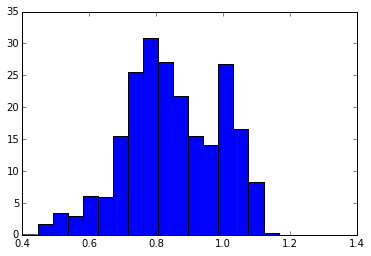

473.420559603
229.074464324


In [1592]:
weight = np.ones(len(colours_sub))/(iterations*back_samples)
plt.figure()
plt.hist(colours_sub, bins=np.arange(0.4,1.35,0.045), weights=weight)
plt.show()

print ((950/60.)**2*np.pi)-(600/60.)**2*np.pi
print ((950/60.)**2*np.pi)-(800/60.)**2*np.pi

In [811]:
#for i in range(len(Subaru_comp['g_i'][Subaru_comp['flag']=="H"])):
    #print (Subaru_comp['g_i'][Subaru_comp['flag']=="H"][i])


In [1593]:
%%bash
mv N4526_GMM_*.in /Users/lchevalier/Desktop/gmm/
cd /Users/lchevalier/Desktop/gmm/
sh GMM_auto.bash
cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor
pwd


/Users/lchevalier/Dropbox/Project1_N4526/sextractor


9.18 12.1519514469
p1 0.795745454545 err1 0.0217151515152 p2 1.0293030303 err1 0.015296969697 0.114145454545 0.011296969697 0.0421212121212 0.00801212121212


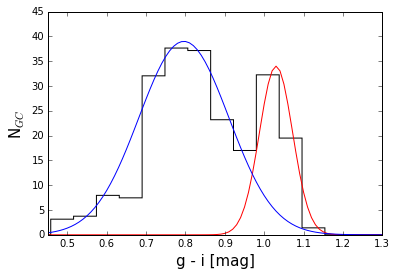

In [1599]:
peak1,err_peak1,peak2,err_peak2,sig1,err_sig1,sig2,err_sig2=np.loadtxt('/Users/lchevalier/Desktop/gmm/prob_N4526_new/gmm.sub.N4526.results',usecols=[1,2,3,4,5,6,7,8],unpack=True)
weight = np.ones(len(colours_sub))/(iterations*back_samples)
plt.hist(colours_sub, bins= np.arange(0.4,1.35,0.058), histtype='step', color='black',weights=weight)
plt.xlim(0.45,1.3)
plt.ylim(0,45)
data2= np.arange(0.45,1.3+0.01,0.01)

# needs a calcualtion for norm!!
#normalisation should be dependatnt on the bin size!
normal= (204)*np.sqrt(2*np.mean(sig1)**2)
normal2= (204)*np.sqrt(2*np.mean(sig2)**2)
print 204*.045, normal2
print 'p1',np.mean(peak1),'err1',np.mean(err_peak1),'p2',np.mean(peak2),'err1',np.mean(err_peak2),np.mean(sig1),np.mean(err_sig1),np.mean(sig2),np.mean(err_sig2)

plt.plot(data2,gaussian(data2,np.median(peak2),np.mean(sig2), norm=34.), color='red')
plt.plot(data2,gaussian(data2,np.median(peak1),np.mean(sig1), norm=39.),color='blue')
plt.xlabel('g - i [mag]', size=15)
plt.ylabel('N$_{GC}$', size=15)
plt.savefig(folder+'GMM_new2.png')

# Background removal


[   5.91499996   55.12900162  136.25275215  296.35868949  493.97512886
  665.93242628]
1
original number of GCs 76.0
total number of GCs in bins 73.9056297682


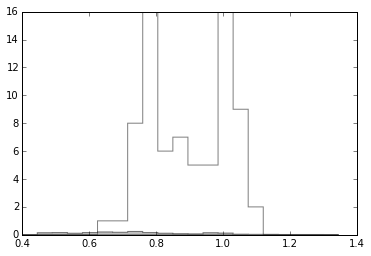

2
original number of GCs 76.0
total number of GCs in bins 65.1764349198


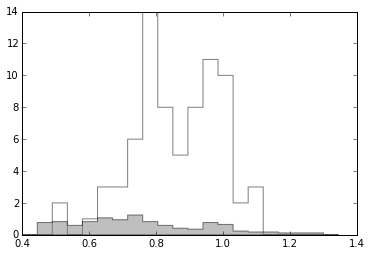

3
original number of GCs 275.0
total number of GCs in bins -102.282786882


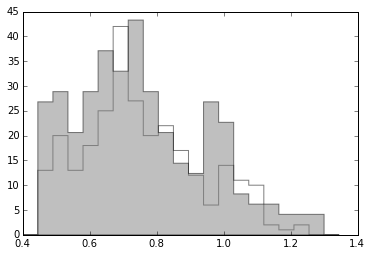

['N4526_dist_3.1.in', 'N4526_dist_3.2.in', 'N4526_dist_3.3.in', 'N4526_dist_3.4.in', 'N4526_dist_3.5.in', 'N4526_dist_3.6.in', 'N4526_dist_3.7.in', 'N4526_dist_3.8.in', 'N4526_dist_3.9.in', 'N4526_dist_3.10.in']


In [1519]:
# taking a distance measurement every 75 GC candidates (sorted by distance first)
# removing the last bin edge and replacing it with the highest GC distance meaure
# the last bin (unless GC no perfectly divisible by step size) will include more objects than the others

bin_rad=np.sort(GDist[GDist<=750])[0::75]
print bin_rad
bin_rad= bin_rad[:-3]
bin_rad = np.append(bin_rad,np.max(GDist[GDist<=750]))

#####################
# colour bins to be used in makign the histogram
bins_back=np.arange(0.4,1.35,0.045)

#####################
#start of the four loop defining the sample going into each file
#seperating binned data into colour bins returning n (number of GCs in colour bin at that distance)



back_ratio =[]
for i in np.arange(0,len(bin_rad)-1,1)+1:
    print i
    plt.figure(i)
    back_ratio=((bin_rad[i]**2*np.pi-bin_rad[i-1]**2*np.pi)/(950**2*np.pi -800**2*np.pi))# ratio between the bin size and the 
    n_dist,b,p = plt.hist(Subaru_comp['g_i'][(Subaru_comp['g_i']>0.45)&(Subaru_comp['g_i']<1.3)&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])], bins=bins_back, normed= False,alpha= 0.5, histtype='step', color='black')
    nb,binsb,patchesb=plt.hist(Subaru_comp['g_i'][outer_sub], bins=bins_back, normed= False,weights=np.ones(len(Subaru_comp[Imag][outer_sub]))*back_ratio, alpha= 0.5, histtype='stepfilled', color='grey')
    edges = bins_back
    
    nx= n_dist-nb
    print 'original number of GCs', sum(n_dist)
    print 'total number of GCs in bins', sum(nx)
    
    names_dist =[]
    for l in range(10):
        colours=[]
        
        names_dist.append('N4526_dist_'+str(i)+'.'+str(l+1)+'.in')
        f = open(names_dist[l], 'w')
        
        for y in range(len(edges)-1):
            #makes array of all the sources in a colour bin (g-i)
            array = Subaru_comp['g_i'][(Subaru_comp['g_i']>0.45)&(Subaru_comp['g_i']<1.3)&(Subaru_comp['g_i']>edges[y])&(Subaru_comp['g_i']<edges[y+1])&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])]
            if bin_rad[i] < 90:
                for e in range(len(array)):
                    f.write(str(array[e])+'\n')
                    colours.append(array[e])
            else:
                for x in range(int(nx[y])):
                    f.write(str(random.choice(array)) +'\n')
                    colours.append(random.choice(array))
        plt.show()
        f.close()
print names_dist


In [694]:
%%bash
mv N4526_dist_*.in /Users/lchevalier/Desktop/gmm/
cd /Users/lchevalier/Desktop/gmm/
sh Aito_gmm_dist.sh
cd /Users/lchevalier/Dropbox/Project1_N4526/sextractor
pwd

/Users/lchevalier/Dropbox/Project1_N4526/sextractor


mv: rename N4526_dist_*.in to /Users/lchevalier/Desktop/gmm/N4526_dist_*.in: No such file or directory


In [1600]:
bin_rad=np.sort(GDist[GDist<=750])[0::75]
print bin_rad
bin_rad= bin_rad[:-3]
bin_rad = np.append(bin_rad,np.max(GDist[GDist<=750]))
print len(bin_rad)


[   5.91499996   55.12900162  136.25275215  296.35868949  493.97512886
  665.93242628]
4


/Users/lchevalier/Desktop/gmm/gmm.N4526_1.results
/Users/lchevalier/Desktop/gmm/gmm.N4526_2.results
/Users/lchevalier/Desktop/gmm/gmm.N4526_3.results
[0.80720000000000025, 0.79957999999999996, 0.74415555555555546]
[1.0187999999999999, 0.99146000000000001, 1.0686444444444443]
blue -0.000155396807428
red 0.000154810218283


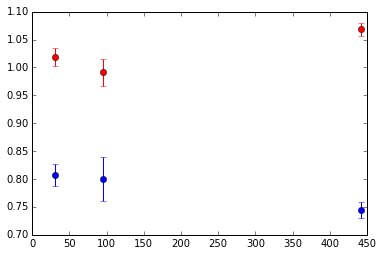

In [1601]:
p_blue=[]
err_b=[]
p_red=[]
err_r=[]
bin_steps =[]
bin_steps =[]
names =["/Users/lchevalier/Desktop/gmm/gmm.N4526_1.results",'/Users/lchevalier/Desktop/gmm/gmm.N4526_2.results','/Users/lchevalier/Desktop/gmm/gmm.N4526_3.results','/Users/lchevalier/Desktop/gmm/gmm.N4526_4.results','/Users/lchevalier/Desktop/gmm/gmm.N4526_5.results']
for i in np.arange(1,len(bin_rad),1):
    print '/Users/lchevalier/Desktop/gmm/gmm.N4526_'+str(i)+'.results'
    a=i-1
    m,n,o,p = np.loadtxt('/Users/lchevalier/Desktop/gmm/gmm.N4526_'+str(i)+'.results', usecols=(1,2,3,4), unpack=True) # returns pb, err_b, pr, err_r
    p_blue.append(np.mean(m))
    err_b.append(np.mean(n))
    p_red.append(np.mean(o))
    err_r.append(np.mean(p))
    bin_steps.append((bin_rad[i-1]+bin_rad[i])/2)
plt.errorbar(bin_steps,p_blue, xerr=0, yerr=err_b, fmt='o')
plt.errorbar(bin_steps,p_red, xerr=0, yerr=err_r, color='red', fmt='o')

print p_blue
print p_red

slope_red, intercept_red, r_value_red, p_value_red, std_err_red = sc.stats.linregress(bin_steps,p_red)
slope_blue, intercept_blue, r_value_blue, p_value_blue, std_err_blue = sc.stats.linregress(bin_steps,p_blue)
print 'blue',slope_blue
print 'red',slope_red

In [ ]:
# definging P1 and P2



[ 0.45   0.508  0.566  0.624  0.682  0.74   0.798  0.856  0.914  0.972
  1.03   1.088  1.146  1.204  1.262  1.32 ]
130 130


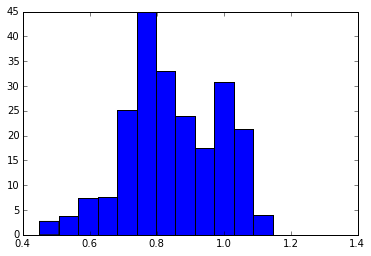

In [1602]:
bins_back=np.arange(0.45,1.35,0.058)
print bins_back
#makes the input list of all the probabilities/colours
P1_new=list()
P2_new=list()
Color=list()

for i in range(back_samples):
    for j in range(iterations):
        p1,p2,color=np.loadtxt('/Users/lchevalier/Desktop/gmm/prob_N4526_new/peakprob.out.'+str(i+1)+'.'+str(j+1),usecols=[0,1,2],unpack=True)
        p1,p2,color=(p1[1:]),(p2[1:]),(color[1:])
        P1_new.extend(p1)
        P2_new.extend(p2)
        Color.extend(color)
weight2=np.ones(len(Color))/ (iterations*back_samples)
plt.hist(Color, bins=bins_back, weights=weight2)
#define array to hold the sampled colour and probability values
sample_prop=[]
sample_colour=[]
#split final catalogue into bins
for i in range(len(bins_back)-1):
    #array_prop = np.array(P1)[(np.array(Color)>bins_back[i])&(np.array(Color)<bins_back[i+1])]
    array_colour = np.array(Color)[(np.array(Color)>bins_back[i])&(np.array(Color)<bins_back[i+1])]
    
    try:
        random_number = np.random.choice(range(0,len(array_colour)-1,1),10)
        
        
    except ValueError:
        pass
#randomly draw a number of objects from these bins 
    for x in np.array(random_number):
        try:
            sample_prop.append(np.mean(np.array(P1_new)[array_colour[x]==np.array(Color)]))
            
            sample_colour.append(array_colour[x])
        except IndexError: 
            pass
print len(sample_colour),len(sample_prop)

130 130
[  0.97408444  19.75893319]


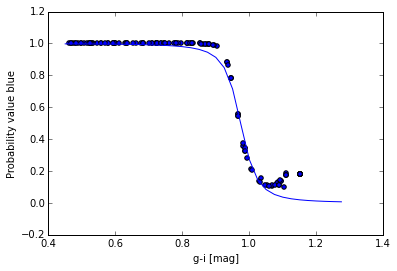

In [1603]:
#works with Sabines fitting cod ebut choose to use scipy.optimize... curvefit!

#k,a=powerLawFit(Subaru_comp['g_i'],np.array(P1),7,50,SamplingNumber=100.)
#k,a=powerLawFit(np.array(sample_colour)[np.array(sample_colour)>=0.8],np.array(sample_prop)[np.array(sample_colour)>=0.8],0.8,1.,SamplingNumber=100.)
#print k,a
#plt.plot(x,Pritchet_f(x,k,a) )


print len(np.array(sample_colour)),len(np.array(sample_prop))
plt.figure()
plt.scatter(sample_colour,sample_prop)

fit_para, other_things = sc.optimize.curve_fit(Pritchet_f,sample_colour,sample_prop)
print fit_para
x= (np.arange(0.45,1.3,0.025))

plt.plot(x,Pritchet_f(x,fit_para[0],fit_para[1]) )
plt.xlabel('g-i [mag]')
plt.ylabel('Probability value blue')
plt.savefig(folder+'probability_fit_blue.png')
plt.show()

In [1604]:

# defining the new probabilities of my entire sample based on the Pritchettt function definition as shown above

P1= [np.round(Pritchet_f(num,fit_para[0],fit_para[1]),2) for num in Subaru_comp['g_i']]
P2= [np.round(1-Pritchet_f(num,fit_para[0],fit_para[1]),2) for num in Subaru_comp['g_i']]
#convert to arrays
P1=np.array(P1)
P2=np.array(P2)

print sum(P2[GDist<750])
red = np.round(P2)
blue =np.round(P1)

85.34


In [1605]:
print 'red', np.sum(P2[(Subaru_comp[Imag]<=22.5)&(GDist>800.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60.)**2.-(800./60.)**2.))
print 'blue',np.sum(P1[(Subaru_comp[Imag]<=22.5)&(GDist>800.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60.)**2.-(800./60.)**2.))
print 'total',len(P2[(Subaru_comp[Imag]<=22.5)&(GDist>800.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60)**2.-(800./60)**2.))

print '####### Colour split #######'

print 'red', np.sum(red[(Subaru_comp[Imag]<=22.5)&(GDist>800.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60.)**2.-(800./60.)**2.))
print 'blue',np.sum(blue[(Subaru_comp[Imag]<=22.5)&(GDist>800.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60.)**2.-(800./60.)**2.))


red 0.0822876528626
blue 0.354251619618
total 0.436539272481
####### Colour split #######
red 0.0785770690465
blue 0.349231417985


# colour split

[   9.73200035   85.72628097  219.19114105  444.62520712  612.22938434
  764.34908899  946.64762976]
6 7
blue -0.000144236874797 0.788333744049 -0.876400367592 0.0219711959926 3.96291814e-05
red 6.74418302046e-05 1.02854131919 0.921225770179 0.00906365693885 1.42401498039e-05
[26.0, 12.0, 9.0, 13.0, 14.0, 20.0]
blue -0.000144236874797 0.788333744049 -0.876400367592 0.0219711959926 3.96291814e-05
red 6.74418302046e-05 1.02854131919 0.921225770179 0.00906365693885 1.42401498039e-05


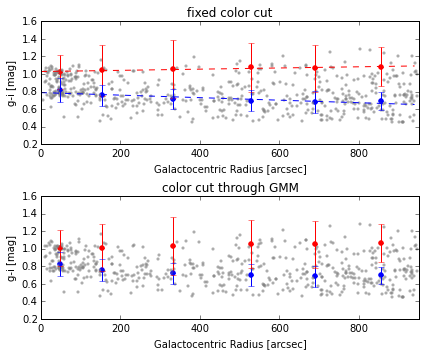

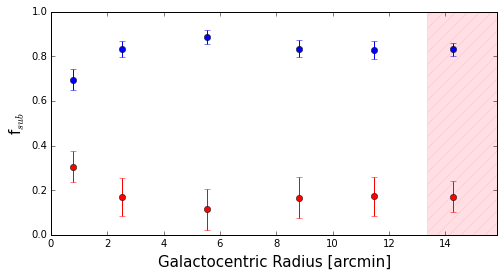

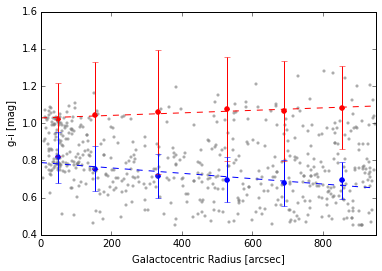

In [1606]:
# plotting change in mean colour for non background subtracted sample

bin_rad=np.sort(GDist[(GDist<950)&(Subaru_comp[Imag]<22.5)])[0::80]

bin_rad= bin_rad[:-1]
bin_rad = np.append(bin_rad,np.max(GDist[GDist<=950]))
print bin_rad

red_average =[]
blue_average = []

P1_average =[]
P2_average =[]
binned=[]
n_r=[]
n_b=[]
n_P1=[]
n_P2=[]
average=[]
rms_P1=[]
rms_P2=[]
for i in np.arange(1,len(bin_rad),1):
    red_average.append(np.average(Subaru_comp['g_i'][(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)], weights=red[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    blue_average.append(np.average(Subaru_comp['g_i'][(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)], weights=blue[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    P2_average.append(np.average(Subaru_comp['g_i'][(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)], weights=P2[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    P1_average.append(np.average(Subaru_comp['g_i'][(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)], weights=P1[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    binned.append((bin_rad[i]+bin_rad[i-1])/2)
    n_r.append(sum(red[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    n_b.append(sum(blue[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    n_P1.append(sum(P1[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    n_P2.append(sum(P2[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    average.append(np.mean(Subaru_comp['g_i'][(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    #rms_red.append()
    #rms_blue.append()
    rms_P1.append(np.std(P1[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    rms_P2.append(np.std(P2[(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]))
    #rms_P2.append()
    
print len(red_average) , len (bin_rad)   
plt.figure(figsize=(6,5))

plt.subplot(211)
plt.xlim(0,950)
plt.title('fixed color cut')
plt.scatter(binned,red_average, color='red')
plt.scatter(binned,blue_average, color='blue')
plt.errorbar(binned,red_average, xerr=0, yerr=1/np.sqrt(n_r), color='red', fmt='.')
plt.errorbar(binned,blue_average, xerr=0, yerr=1/np.sqrt(n_b),color='blue', fmt='.')
#plt.plot(binned,average,color='grey')
plt.scatter(GDist[GDist<950], Subaru_comp['g_i'][GDist<950], color='grey', alpha=0.5, s=5)
x=np.arange(0,950,10)
slope_red, intercept_red, r_value_red, p_value_red, std_err_red = sc.stats.linregress(binned,red_average)
slope_blue, intercept_blue, r_value_blue, p_value_blue, std_err_blue = sc.stats.linregress(binned,blue_average)
print 'blue',slope_blue, intercept_blue, r_value_blue, p_value_blue, std_err_blue
print 'red',slope_red, intercept_red, r_value_red, p_value_red, std_err_red
plt.plot(x,slope_red*x+intercept_red,ls='--', color='r')
plt.plot(x,slope_blue*x+intercept_blue,ls='--', color='b')
plt.ylabel('g-i [mag]')
plt.xlabel('Galactocentric Radius [arcsec]')

plt.subplot(212)
plt.xlim(0,950)
plt.title('color cut through GMM')
plt.scatter(binned,P2_average, color='red')
plt.scatter(binned,P1_average, color='blue')
plt.errorbar(binned,P1_average, xerr=0, yerr=1/np.sqrt(n_P1),color='blue', fmt='.')
plt.errorbar(binned,P2_average, xerr=0, yerr=1/np.sqrt(n_P2),color='red', fmt='.')
plt.scatter(GDist[(GDist<950)&(Subaru_comp[Imag]<22.5)], Subaru_comp['g_i'][(GDist<950)&(Subaru_comp[Imag]<22.5)], color='grey', alpha=0.5, s=5)
#plt.plot(binned,average,color='grey')
plt.ylabel('g-i [mag]')
plt.xlabel('Galactocentric Radius [arcsec]')
plt.tight_layout()

plt.savefig(folder+'non_background suptracted-colour gradients.png')

plt.figure(figsize=(8,4))
#plt.scatter(binned,n_P1/(np.array(n_P1)+np.array(n_P2)), color='blue')
#plt.scatter(binned,n_P2/(np.array(n_P1)+np.array(n_P2)), color='red')
plt.errorbar(np.array(binned)/60.,n_P1/(np.array(n_P1)+np.array(n_P2)), xerr=0, yerr=rms_P1/np.sqrt(n_b),color='blue', fmt='o')
plt.errorbar(np.array(binned)/60.,n_P2/(np.array(n_P1)+np.array(n_P2)), xerr=0, yerr=rms_P2/np.sqrt(n_r),color='red', fmt='o')
plt.xlabel('Galactocentric Radius [arcmin]', size=15)
plt.ylabel('f$_{sub}$', size=15)
plt.axvspan(800/60., 950/60., color='pink', alpha=0.5, hatch ='//')
plt.xlim(0,950./60.)
plt.savefig(folder+'fraction_over_dist.png')
print n_r


plt.figure()
plt.xlim(0,950)
#plt.title('fixed color cut')
plt.scatter(binned,red_average, color='red')
plt.scatter(binned,blue_average, color='blue')
plt.errorbar(binned,red_average, xerr=0, yerr=1/np.sqrt(n_r), color='red', fmt='.')
plt.errorbar(binned,blue_average, xerr=0, yerr=1/np.sqrt(n_b),color='blue', fmt='.')
#plt.plot(binned,average,color='grey')
plt.scatter(GDist[GDist<950], Subaru_comp['g_i'][GDist<950], color='grey', alpha=0.5, s=5)
x=np.arange(0,950,10)
slope_red, intercept_red, r_value_red, p_value_red, std_err_red = sc.stats.linregress(binned,red_average)
slope_blue, intercept_blue, r_value_blue, p_value_blue, std_err_blue = sc.stats.linregress(binned,blue_average)
print 'blue',slope_blue, intercept_blue, r_value_blue, p_value_blue, std_err_blue
print 'red',slope_red, intercept_red, r_value_red, p_value_red, std_err_red
plt.plot(x,slope_red*x+intercept_red,ls='--', color='r')
plt.plot(x,slope_blue*x+intercept_blue,ls='--', color='b')
plt.ylabel('g-i [mag]')
plt.xlabel('Galactocentric Radius [arcsec]')
#plt.axvspan(800/60., 950/60., color='pink', alpha=0.5, hatch ='//')
plt.savefig(folder+'fixed-colour_cut_gradient.png')
plt.show()



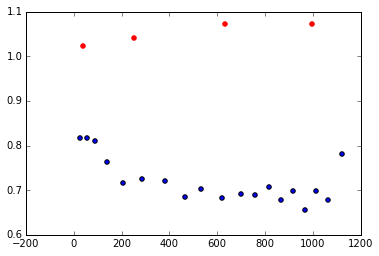

In [1607]:
dist_blue=np.sort(GDist[P1>=0.5])[0::30]
dist_red=np.sort(GDist[P2>=0.5])[0::30]
colour_blue = Subaru_comp['g_i'][P1>=0.5]
colour_red =Subaru_comp['g_i'][P2>=0.5]
mean_blue=[]
mean_red=[]
bin_blue=[]
bin_red=[]
for i in range(len(dist_blue)-1):
    mean_blue.append(np.mean(colour_blue[(GDist[P1>=0.5]>=dist_blue[i])&(GDist[P1>=0.5]<dist_blue[i+1])]))
    bin_blue.append((dist_blue[i+1]+dist_blue[i])/2)
for i in range(len(dist_red)-1):
    mean_red.append(np.mean(colour_red[(GDist[P2>=0.5]>=dist_red[i])&(GDist[P2>=0.5]<dist_red[i+1])]))
    bin_red.append((dist_red[i+1]+dist_red[i])/2)
    
plt.scatter(bin_blue,mean_blue)
plt.scatter(bin_red,mean_red, color='r')

In [1608]:
print P1[1],P2[1]

0.98 0.02


In [1923]:
def colour_gradient(no_gcs,subpopulation,Dist,cut):
    
    
    dist_blue=np.sort(GDist[(subpopulation>=0.5)&(Dist<=cut)])[0::no_gcs]
    
    
    #####################
    # colour bins to be used in makign the histogram
    bins_back=np.arange(0.4,1.35,0.05)

    #####################
    #start of the four loop defining the sample going into each file
    #seperating binned data into colour bins returning n (number of GCs in colour bin at that distance)

    na=[]#poission error on bin
    colour_std=[]
    middle_bin=[]
    back_ratio =[]
    mean_colour =[]
    colour_var=[]
    for i in np.arange(0,len(dist_blue)-1,1)+1:
        #print i
        plt.figure(i)
        back_ratio=((dist_blue[i]**2*np.pi-dist_blue[i-1]**2*np.pi)/(950**2*np.pi -650**2*np.pi))# ratio between the bin size and the 
        n_dist,b,p = plt.hist(Subaru_comp['g_i'][(subpopulation>=0.5)&(Dist<dist_blue[i])& (Dist>=dist_blue[i-1])], bins=bins_back, normed= False,alpha= 0.5, histtype='step', color='black')
        nb,binsb,patchesb=plt.hist(Subaru_comp['g_i'][(outer_sub)], bins=bins_back, normed= False,weights=np.ones(len(Subaru_comp[Imag][(outer_sub)]))*back_ratio, alpha= 0.5, histtype='stepfilled', color='grey')
        edges = bins_back
        middle_bin.append((dist_blue[i]+dist_blue[i-1])/2)
        nx= n_dist-nb
        
        na.append(sum(nx[nx>0]))
        #print middle_bin
        for l in range(3): # for looping multiple times 
            colours=[]
            try:
                for y in range(len(edges)-1):
                    #makes array of all the sources in a colour bin (g-i)
                    array = Subaru_comp['g_i'][(subpopulation>=0.5)&(Subaru_comp['g_i']>edges[y])&(Subaru_comp['g_i']<edges[y+1])&(Dist<=bin_rad[i])& (Dist>=bin_rad[i-1])]
                    if bin_rad[i] < 90:
                        for e in range(len(array)):

                            colours.append(array[e])
                    else:
                        for x in range(int(nx[y])):
                            colours.append(random.choice(array))
                            
                plt.close()
            except:
                plt.close()
                #colours.append(-99)
                pass
        #print np.mean(colours)
        #try:
        colour_std.append(np.std(colours))
        colour_var.append(np.var(colours))
        mean_colour.append(np.mean(colours))
        #except:
            #colour_std.append(-99)
            #mean_colour.append(-99)
    mean_colour=np.array(mean_colour)[~np.isnan(np.array(mean_colour))]
    middle_bin=np.array(middle_bin)[~np.isnan(np.array(mean_colour))]
    na=np.array(na)[~np.isnan(np.array(mean_colour))]
    colour_std=np.array(colour_std)[~np.isnan(np.array(mean_colour))]
    colour_var=np.array(colour_var)[~np.isnan(np.array(mean_colour))]
    err=1/np.sqrt(na)  #colour_std/np.sqrt(na)        

    return np.array(mean_colour), np.array(middle_bin),np.array(err),np.array(na),np.array(colour_std),np.array(colour_var)


In [1941]:
trial=colour_gradient(75,subpopulation=P1,Dist=GDist,cut=850)
red_trial=colour_gradient(25,subpopulation=P2,Dist=GDist,cut=850)
print np.mean(trial[2])
print ~np.isnan(trial[3])

0.182785766253
[ True  True  True  True  True]


In [1932]:
for i in trial:
    print i

[ 0.82143024  0.81554475  0.72687144  0.76536918  0.72282333  0.62541618]
[  33.55750036  101.40999794  208.86839355  366.10089248  523.17959079
  659.83247616]
[ 0.1357783   0.14013479  0.16180006  0.21914963  0.23141511  0.35241885]
[ 54.24244921  50.92230427  38.19817693  20.82181091  18.67310683
   8.05159144]
[ 0.08640108  0.09372403  0.09435334  0.06272181  0.14261731  0.12016023]
[ 0.00746515  0.00878419  0.00890255  0.00393403  0.0203397   0.01443848]


In [9]:
def wlinear_fit (x,y,w) :
    """
    Fit (x,y,w) to a linear function, using exact formulae for weighted linear
    regression. This code was translated from the GNU Scientific Library (GSL),
    it is an exact copy of the function gsl_fit_wlinear. It takes the inverse variance rather then invers std.
    The best estimate on the error on a is then the square root of cov_00 
    and the one on b is the square root of cov_11.
    """
    # compute the weighted means and weighted deviations from the means
    
    # wm denotes a "weighted mean", wm(f) = (sum_i w_i f_i) / (sum_i w_i)
    W = np.sum(w)
    wm_x = np.average(x,weights=w)
    wm_y = np.average(y,weights=w)
    dx = x-wm_x
    dy = y-wm_y
    wm_dx2 = np.average(dx**2,weights=w)
    wm_dxdy = np.average(dx*dy,weights=w)
    # In terms of y = a + b x
    b = wm_dxdy / wm_dx2
    a = wm_y - wm_x*b
    cov_00 = (1.0/W) * (1.0 + wm_x**2/wm_dx2)
    cov_11 = 1.0 / (W*wm_dx2)
    cov_01 = -wm_x / (W*wm_dx2)
    # Compute chi^2 = \sum w_i (y_i - (a + b * x_i))^2
    chi2 = np.sum (w * (y-(a+b*x))**2)
    
    return a,b,np.sqrt(cov_00),np.sqrt(cov_11),cov_01,chi2

In [1942]:
cg_intercept,cg_slope,cg_intercept_err,cg_slope_err, cov, chi2=wlinear_fit((trial[1]/60.),trial[0],1/trial[5])
print (wlinear_fit(np.log10(trial[1]/60.),trial[0],1/trial[5]))
print (wlinear_fit((trial[1]/60.),trial[0],1/trial[5]))

(0.80960790718829334, -0.096490933675396143, 0.070853061978239276, 0.10089277870579402, -0.0054686707942064334, 0.036792908104340487)
(0.81050856853266406, -0.0098824961013802733, 0.073887688157259768, 0.010889666780598984, -0.00063283649871876324, 0.12786167796100381)


[ 0.08640108  0.10338621  0.09011851  0.1515645   0.10778155]
y=-0.00988249610138x+0.810508568533
blue -0.00988249610138 0.810508568533 0.0108896667806 0.0738876881573


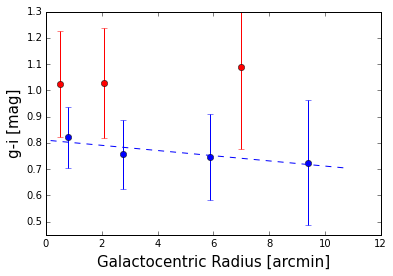

In [1943]:
print trial[-2]
plt.figure()
x=np.arange(10,650,10)/60.
#plt.xlim(0,900)
plt.ylim(0.45,1.3)
plt.errorbar(trial[1][:-1]/60.,trial[0][:-1],yerr=trial[2][:-1], fmt='o')
plt.errorbar(red_trial[1]/60.,red_trial[0],yerr=red_trial[2], fmt='o',color='red')
#slope_red, intercept_red, r_value_red, p_value_red, std_err_red = sc.stats.linregress(np.log10(red_trial[1]),red_trial[0])
print 'y='+str(cg_slope)+'x+'+str(cg_intercept)

#slope_blue, intercept_blue, r_value_blue, p_value_blue, std_err_blue = sc.stats.linregress(np.log10(trial[1]),trial[0])
print 'blue',(cg_slope), (cg_intercept), cg_slope_err, cg_intercept_err
#print 'red',(slope_red), (intercept_red), r_value_red, p_value_red, std_err_red
#plt.plot(x,(slope_red)*np.log10(x)+intercept_red,ls='--', color='r')
plt.plot(x,(cg_slope)*(x)+cg_intercept,ls='--', color='b')
plt.ylabel('g-i [mag]', size=15)
plt.xlabel('Galactocentric Radius [arcmin]', size=15)
plt.savefig(folder+'colour_gradient.png')

In [1636]:
sum(P2[GDist<750])
import matplotlib.axes as ax

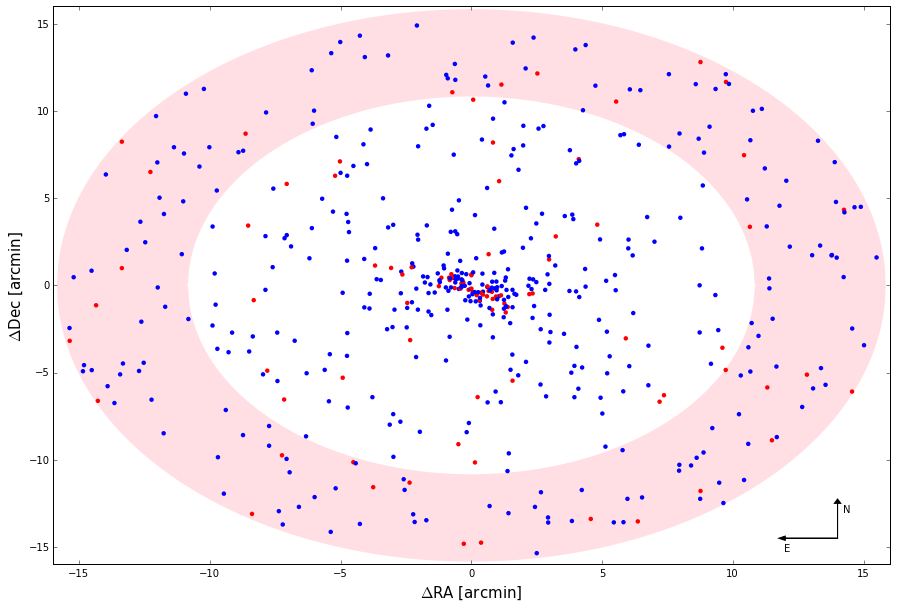

0.755205634896


In [1944]:
fig =plt.figure(figsize=(15,10))
plt.ylabel('$\Delta$Dec [arcmin]',size=15)
plt.xlabel('$\Delta$RA [arcmin]',size=15)
ax = fig.add_subplot(1, 1, 1)
outer_sub_draw =[(GDist>750)&(GDist<950)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)& (Subaru_comp[Imag]<22.5)]
#plt.scatter(Subaru_comp['new_RA'][GDist<=750]-188.51262, Subaru_comp['new_Dec'][GDist<=750]-7.6991162, c=P1[GDist<=750], cmap='seismic')
#plt.scatter(Subaru_comp['new_RA'][outer_sub]-188.51262, Subaru_comp['new_Dec'][outer_sub]-7.6991162, c=P1[outer_sub], cmap='seismic')

inner = 0.1805*60
outer = 0.264*60

x = np.linspace(-outer, outer, 1000, endpoint=True)

yO = outer*np.sin(np.arccos(x/outer)) # x-axis values -> outer circle
yI = inner*np.sin(np.arccos(x/inner)) # x-axis values -> inner circle (with nan's beyond circle)
yI[np.isnan(yI)] = 0.                 


ax.fill_between(x, yI, yO, color="pink",alpha=0.5,edgecolor='None')
ax.fill_between(x, -yO, -yI, color="pink", alpha=0.5,edgecolor='None')
plt.scatter((188.51262-Subaru_comp['new_RA'][(GDist<=750)&(Subaru_comp[Imag]<22.5)])*60, (7.6991162-Subaru_comp['new_Dec'][(GDist<=750)&(Subaru_comp[Imag]<22.5)])*60, c=np.round(P2[(GDist<=750)&(Subaru_comp[Imag]<22.5)]), cmap='bwr',edgecolor='None')
plt.scatter((188.51262-Subaru_comp['new_RA'][outer_sub_draw])*60,(7.6991162 -Subaru_comp['new_Dec'][outer_sub_draw])*60, c=np.round(P2[outer_sub_draw]), cmap='bwr',edgecolor='None')
#plt.colorbar()
plt.xlim(-16,16)
plt.ylim(-16,16)

ax.arrow( 14,-14.5, 0, 2, head_width=0.25, head_length=0.25, fc='k', ec='k', capstyle='projecting')
ax.arrow( 14,-14.5, -2, 0, head_width=0.25, head_length=0.25, fc='k', ec='k',capstyle='projecting')
ax.annotate('N', xy=(14, -15), xytext=(14.25, -13))
ax.annotate('E', xy=(12, -15), xytext=(12, -15.25))
plt.savefig(folder+'Area distribution')
plt.show()

print np.mean(Subaru_comp['g_i'][outer_sub_draw])

40.18


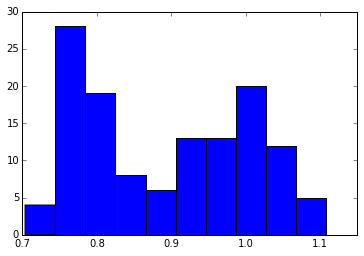

In [1638]:
plt.hist(Subaru_comp['g_i'][Subaru_comp['flag']=='H'])
print (sum(P2[(Subaru_comp['flag']=='H')]))

# Sersic Profiles 

In [1869]:
def make_dist_array():
    '''should evebtually be adjusted so it takes different inout values...
     taking a distance measurement every 75 GC candidates (sorted by distance first)
     removing the last bin edge and replacing it with the highest GC distance meaure
     the last bin (unless GC no perfectly divisible by step size) will include more objects than the others'''
    
    bin_rad=np.sort(GDist[Subaru_comp[Imag]<=22.5])[0::85]
    #print bin_rad
    bin_rad= bin_rad[:-3]
    bin_rad = np.append(bin_rad,np.max(GDist[Subaru_comp[Imag]<22.5]))
    
    #####################
    # colour bins to be used in makign the histogram
    bins_back=np.arange(0.4,1.35,0.045)
    
    #####################
    #start of the four loop defining the sample going into each file
    #seperating binned data into colour bins returning n (number of GCs in colour bin at that distance)
    
    
    c = random.randint(650,800)
    k= 950.
    outer_sub =[(Subaru_comp['flag']!='H')&(GDist>c)&(GDist<k)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)& (Subaru_comp[Imag]<22.5)]
    area= ((k)**2*np.pi) -((c)**2*np.pi)
    
    back_ratio =[]
    distances=[]
    distances_blue=[]
    distances_red=[]
    for i in np.arange(0,len(bin_rad)-1,1)+1:
        
        #print i
        plt.figure(i)
        back_ratio=((bin_rad[i]**2*np.pi-bin_rad[i-1]**2*np.pi)/area)# ratio between the bin size and the 
        n_dist,b,p = plt.hist(Subaru_comp['g_i'][(Subaru_comp['flag']!='H')&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)], bins=bins_back, normed= False,alpha= 0.5, histtype='step', color='black')
        nb,binsb,patchesb=plt.hist(Subaru_comp['g_i'][outer_sub], bins=bins_back, normed= False,weights=np.ones(len(Subaru_comp[Imag][outer_sub]))*back_ratio, alpha= 0.5, histtype='stepfilled', color='grey')
        edges = bins_back
        
        n_dist_blue,b,p = plt.hist(Subaru_comp['g_i'][(Subaru_comp['flag']!='H')&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)], bins=bins_back,weights=P1[(Subaru_comp['flag']!='H')&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)] ,normed= False,alpha= 0.5, histtype='step', color='black')
        nb_blue,binsb,patchesb=plt.hist(Subaru_comp['g_i'][outer_sub], bins=bins_back, normed= False,weights=blue[outer_sub]*back_ratio, alpha= 0.5, histtype='stepfilled', color='grey')
        
        n_dist_red,b,p = plt.hist(Subaru_comp['g_i'][(Subaru_comp['flag']!='H')&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)],weights=P2[(Subaru_comp['flag']!='H')&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)], bins=bins_back, normed= False,alpha= 0.5, histtype='step', color='black')
        nb_red,binsb,patchesb=plt.hist(Subaru_comp['g_i'][outer_sub], bins=bins_back, normed= False,weights=red[outer_sub]*back_ratio, alpha= 0.5, histtype='stepfilled', color='grey')
        plt.close()
        
        nx= n_dist-nb
        nx_blue =n_dist_blue-nb_blue
        nx_red =n_dist_red-nb_red
        #print 'original number of GCs', sum(n_dist)
        #print 'total number of GCs in bins', sum(nx), sum(nx_blue), sum(nx_red)
        
        for y in range(len(edges)-1):
                #makes array of all the sources in a colour bin (g-i)
            array = GDist[(Subaru_comp['flag']!='H')&(Subaru_comp['g_i']>edges[y])&(Subaru_comp['g_i']<edges[y+1])&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]
            #needs a new array for 
            array_blue = GDist[(Subaru_comp['flag']!='H')&(Subaru_comp['g_i']>edges[y])&(Subaru_comp['g_i']<edges[y+1])&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)&(blue>=0.5)]
            array_red = GDist[(Subaru_comp['flag']!='H')&(Subaru_comp['g_i']>edges[y])&(Subaru_comp['g_i']<edges[y+1])&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)&(red>=0.5)]
            
            
            HST_array = GDist[(Subaru_comp['flag']=='H')&(Subaru_comp['g_i']>edges[y])&(Subaru_comp['g_i']<edges[y+1])&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)]
            #needs a new array for 
            HST_array_blue = GDist[(Subaru_comp['flag']=='H')&(Subaru_comp['g_i']>edges[y])&(Subaru_comp['g_i']<edges[y+1])&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)&(blue>=0.5)]
            HST_array_red = GDist[(Subaru_comp['flag']=='H')&(Subaru_comp['g_i']>edges[y])&(Subaru_comp['g_i']<edges[y+1])&(GDist<=bin_rad[i])& (GDist>=bin_rad[i-1])&(Subaru_comp[Imag]<22.5)&(red>=0.5)]
            
            
            try:        
#moving all the HST distances into the array to be saved from random sampeling

                #if bin_rad[i] < 85:
                    #for e in range(len(array)):
                        #distances.append(array[e])
                    #for m in range(len(array_blue)):    
                        #distances_blue.append(array_blue[m])
                    #for g in range(len(array_red)):
                        #distances_red.append(array_red[g])
                #else:
                for x in range(int(nx[y])):
                    distances.append(random.choice(array))
                for x in range(int(nx_blue[y])):
                    distances_blue.append(random.choice(array_blue))
                for x in range(int(nx_red[y])):
                    distances_red.append(random.choice(array_red))
                    
                for x in HST_array:
                    distances.append(x)
                for x in HST_array_blue:
                    distances_blue.append(x)
                for x in HST_array_red:
                    distances_red.append(x)
            
            except:
                pass
    distances=np.array(distances)/60.
    distances_blue=np.array(distances_blue)/60.
    distances_red=np.array(distances_red)/60.

    return distances, distances_blue,distances_red

In [1814]:
def many_sersic_tests( ): # function to plot the result of several sersic tests

    plt.figure( 5 ) ; plt.clf()
    result_list = [ test_sersic_fitting( seed=None )
                    for i in xrange( 30 ) ]
    return np.array( result_list )

def test_sersic_fitting(input_data,bg):#(m=2.5, Re=300., Ntot=800, seed=3121 ): # input as firstguesses in pars 
#Ntot should be the total number of GCs originally contained in sample
#seed won't be nececary if I don"t want to generate fake data ? 
    
    xdata =input_data#np.true_divide(np.array(distances)[(np.array(distances)<=750)],1.) #generate_fake_GC_data( m, Re, Ntot, seed=seed ) # try with overwriting this line with input for the actual data that I want to fit !!
    back=bg
    def sersic_negloglike(pars,xdata,back, Rtrunc=950./60.):
        [ m, Re ] = pars
        
        loglike = np.log( 2. * np.pi * xdata 
                          * sersic_profile( xdata, m=m, Re=Re, Rtrunc=Rtrunc , bg=back) )
        result = - np.nansum( loglike ) + np.log( m ) + np.log( Re )
        #print 'index:',m,'Re:', Re,'result:', result
        #norm = sersic_profile( xdata, m=m, Re=Re, Rtrunc=Rtrunc )[1]
        #print np.nansum( loglike )
        return result
        
    firstguess = ( 2., 2.5)
    result = opt.fmin( sersic_negloglike, firstguess, args=(xdata,bg) ) # needs to include statement for norm
    



    return result
    
# ______________________________________________________________________________
# ______________________________________________________________________________

def generate_fake_GC_data( m=1.5, Re=250., Ntot=800, seed=3121 ): # generates fake data 
#    print seed
    if seed > 0 :                    
        np.random.seed( seed )
    logRonRe = np.linspace( -2., 3., 5001 )
    R = Re * 10**logRonRe

    R = np.arange( 0.e-3, 20.+1e-4, 1e-3 ) * Re
    dLdR = sersic_profile( R, m, Re )

    L = integrate.cumtrapz( 2. * np.pi * R * dLdR, R ) # 2 pi in there for normalisation?
    L = np.hstack( [0., L] )
    L /= L.max()
    
    x = np.interp( np.random.rand( Ntot ), L, R )

    plt.figure( 2 ) ; plt.clf()
    plt.plot( R/Re, Ntot*L, 'r-' )
    plt.plot( np.sort( x )/Re, np.arange( x.size ), 
              'k-', drawstyle='steps-pre' )

    return x
    
# ______________________________________________________________________________
# ______________________________________________________________________________

def sersic_profile( R, m,bg, Re=1., N=1., Rtrunc=950./60. ):
    # where R is the inout radii easures
    # mn is the sersic index
    # Re and N are the first guesses for the effective radius and the surface density of
    # GCs at the effective radius (that why we have to have the normalisation factor as the total number is defined by the integral)
    #The truncation radius is important due to the slope having a massive influence on how many GCs will be found 
    #
    #
    b = sersic_b( m ) # defines bn where we used an approximation for bn beforehand! see Pota et al.
    norm = ( Re**2.*2.*np.pi * m * np.exp( b )
             / ( b**( 2.*m ) ) * gamma( 2.*m ) )# define the normalisation factor which is needed because N != Ntot /2 
    
    # norm is the total flux to inifinity (hence complete gamma function)
    if Rtrunc > 0 :
        x = b * (Rtrunc / Re)**(1./m)
        norm *= gammainc( 2.*m, x ) 
    f = (((N * np.exp( -b * ( (R / Re)**(1./m) - 1. ) )) )/ norm )
    if Rtrunc > 0 : # truncation radius has a large influence on how many objects one ends up with (variation in slope etc.). make sure to define a truncation radius where possible
        return np.where( R <= Rtrunc, f, np.nan )
    else :
        return f
# ______________________________________________________________________________

def sersic_b( m ):
    return opt.brentq( sersic_to_solve, 0., 2. * m, args=(m,),
                       xtol=1e-6, rtol=1e-6 )
# ______________________________________________________________________________

def sersic_to_solve( bm, m ):
    # solution to eq 4 in Graham & Driver (2005)
    # note different definition of gammainc compared to G&D05!!!
    return gamma( 2*m ) * ( 1 - 2. * gammainc(2*m, bm) )
# ______________________________________________________________________________
# ______________________________________________________________________________


In [1913]:
print 'red', np.sum(P2[(Subaru_comp[Imag]<=22.5)&(GDist>750.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60.)**2.-(700./60.)**2.))
print 'blue',np.sum(P1[(Subaru_comp[Imag]<=22.5)&(GDist>750.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60.)**2.-(700./60.)**2.))
print 'total',len(P2[(Subaru_comp[Imag]<=22.5)&(GDist>750.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60)**2.-(700./60)**2.))

print '####### Colour split #######'

print 'red', np.sum(red[(Subaru_comp[Imag]<=22.5)&(GDist>750.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60.)**2.-(750./60.)**2.))
print 'blue',np.sum(blue[(Subaru_comp[Imag]<=22.5)&(GDist>750.)&(GDist<950.)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)])/(np.pi*((950./60.)**2.-(750./60.)**2.))

x1 = (900. / 150.)**(1./2)
x2 = (300. / 150.)**(1./2)
print gammainc( 2.*2., x1 ), gammainc( 2.*2., x2 ) 

red 0.0598376286406
blue 0.304077383055
total 0.363915011695
####### Colour split #######
red 0.0674067994272
blue 0.367367056878
0.23168320482 0.0553412203626


In [2054]:
indexcies =[]
half_light_radii = []
indexcies_blue =[]
half_light_radii_blue = []
indexcies_red =[]
half_light_radii_red = []
number_gc =[]
number_gc_blue=[]
number_gc_red=[]
for i in range(20):
    distances,distances_blue,distances_red=make_dist_array()
    
    index,half_rad = test_sersic_fitting(distances[np.array(distances)<=650/60.],0.)
    index_blue,half_rad_blue = test_sersic_fitting(distances_blue[np.array(distances_blue)<=650/60.],0.)
    index_red,half_rad_red = test_sersic_fitting(distances_red[np.array(distances_red)<=450/60.],0.)
    
    indexcies.append(index)
    indexcies_blue.append(index_blue)
    indexcies_red.append(index_red)
    half_light_radii.append(half_rad)
    half_light_radii_blue.append(half_rad_blue)
    half_light_radii_red.append(half_rad_red)
    
    bn= sersic_b(index)
    test = ((index*np.exp(bn)/bn**(2.*index)) *gamma(2.*index))
    Ne=(0.5*len(np.array(distances[np.array(distances)<=650/60.]))/(np.pi* (half_rad)**2.))#/60.
    number_gc.append((Ne)/test)
    
    bn_blue= sersic_b(index_blue)
    Ne_blue=(0.5*len(np.array(distances_blue[np.array(distances_blue)<=650/60.]))/(np.pi* (half_rad_blue)**2.)) #/60.
    number_gc_blue.append(Ne_blue/((index_blue*np.exp(bn_blue)/bn_blue**(2.*index_blue)) *gamma(2.*index_blue)))


    bn_red= sersic_b(index_red)
    Ne_red=(0.5*len(np.array(distances_red[np.array(distances_red)<=450/60.]))/(np.pi* (half_rad_red)**2.)) #/60.
    number_gc_red.append(Ne_red/((index_red*np.exp(bn_red)/bn_red**(2.*index_red)) *gamma(2.*index_red)))

    
index=np.mean(indexcies)
half_rad=np.mean(half_light_radii)
index_blue=np.mean(indexcies_blue)
half_rad_blue=np.mean(half_light_radii_blue)
index_red=np.mean(indexcies_red)
half_rad_red=np.mean(half_light_radii_red)
nh = np.mean(number_gc)
nh_blue = np.mean(number_gc_blue)
nh_red = np.mean(number_gc_red)
print 'total', nh,index, half_rad
print 'blue',nh_blue,index_blue, half_rad_blue
print 'red',nh_red, index_red, half_rad_red

Optimization terminated successfully.
         Current function value: 366.794232
         Iterations: 33
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 279.408348
         Iterations: 31
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 46.184925
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 380.967330
         Iterations: 34
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 283.461935
         Iterations: 36
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 42.735835
         Iterations: 48
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 369.312526
         Iterations: 32
         Function evaluations: 60
Optimization terminate

In [2056]:
print 'total', nh,index, half_rad
print 'blue',nh_blue,index_blue, half_rad_blue
print 'red',nh_red, index_red, half_rad_red

total 2.71964426508 1.99355917653 2.05782201623
blue 1.96493244727 1.67979661977 2.1771515469
red 2.51119151898 1.3138048113 1.03148218062


In [2057]:
def error_on_mean(data):
    error = np.median(bootstrap(data, 100, sigmaG, kwargs=dict(axis=1)))
    return error

print'total'
print np.median(bootstrap(indexcies, 1000, sigmaG, kwargs=dict(axis=1)))
print np.median(bootstrap(half_light_radii, 1000, sigmaG, kwargs=dict(axis=1)))#np.std(half_light_radii)/np.sqrt(len(half_light_radii))
print np.median(bootstrap(number_gc, 1000, sigmaG, kwargs=dict(axis=1)))#np.std(number_gc)/np.sqrt(len(number_gc))
print 'blue'
print np.median(bootstrap(indexcies_blue, 1000, sigmaG, kwargs=dict(axis=1)))
print np.median(bootstrap(half_light_radii_blue, 1000, sigmaG, kwargs=dict(axis=1)))
print np.median(bootstrap(number_gc_blue, 1000, sigmaG, kwargs=dict(axis=1)))
print 'red'
print np.median(bootstrap(indexcies_red, 1000, sigmaG, kwargs=dict(axis=1)))
print np.median(bootstrap(half_light_radii_red, 1000, sigmaG, kwargs=dict(axis=1)))
print np.median(bootstrap(number_gc_red, 1000, sigmaG, kwargs=dict(axis=1)))


total
0.0537201062435
0.0748116025442
0.133155369575
blue
0.0582979647276
0.0648661071026
0.0946271442992
red
0.0727142552319
0.0215905861967
0.151937380739


In [2058]:
distances_flag =[]
distances_red_flag =[]
distances_blue_flag=[]
for i in range(len(distances)):
    distances_flag.append(Subaru_comp['flag'][np.where(distances[i]==GDist/60.)][0])
for i in range(len(distances_red)):
    distances_red_flag.append(Subaru_comp['flag'][np.where(distances_red[i]==GDist/60.)][0])
for i in range(len(distances_blue)):
    distances_blue_flag.append(Subaru_comp['flag'][np.where(distances_blue[i]==GDist/60.)][0])
#print distances_flag

# red blue seperation won't quite work that way
distances_flag = np.array(distances_flag)
distances_red_flag= np.array(distances_red_flag)
distances_blue_flag= np.array(distances_blue_flag)

print len(distances)
#print distances[(distances_flag== 'H')]

211


In [2059]:
GDist

array([  116.85900116,    63.42699814,    37.1570015 ,    63.98300171,
          88.75900269,    61.70899963,    80.43800354,    32.02799988,
          55.5530014 ,    35.86299896,    47.74000168,    17.5170002 ,
          90.52899933,    28.04400063,    29.01399994,    12.77799988,
         126.03299713,    61.20000076,    24.08799934,    45.32600021,
          84.43499756,    19.3560009 ,    14.59200001,   112.85199738,
          48.31600189,    50.69400024,    24.41699982,     5.91499996,
          55.09899902,    19.77700043,    75.63899994,    38.31100082,
          24.04599953,   560.71317376,   986.83847629,   632.45822105,
         828.68592241,    96.76200104,  1385.08800429,   514.46843292,
        1169.11407954,   946.64762976,   501.7911647 ,   612.22938434,
         384.13046465,   199.25912707,   729.91361608,   456.08499298,
         614.55516704,   456.57346868,   356.94736452,   446.13367059,
         745.89097058,   897.36729886,   914.28790022,   843.43395494,
      

In [2060]:
print len(P1[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')]),len(GDist[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')])

95 95


In [2061]:

A=surface_density(GDist[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],P1[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],P2[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],DBins=np.true_divide(np.array([9.,50.,80.]),60),scale='arcmin', plotting=False,match=True,blue_red = True)
B=surface_density(GDist[(Subaru_comp[Imag]<=22.5)],P1[(Subaru_comp[Imag]<=22.5)],P2[(Subaru_comp[Imag]<=22.5)],DBins=np.array(np.true_divide([80,139.,264.,445.,701.,886.,950.],60)), match=True, plotting=False,index=2.0, blue_red = True)

C=surface_density(GDist[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],blue[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],red[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],DBins=np.true_divide(np.array([5,41,80]),60),scale='arcmin',plotting=False, match=True,blue_red = True)
D=surface_density(GDist[(Subaru_comp[Imag]<=22.5)],blue[(Subaru_comp[Imag]<=22.5)],red[(Subaru_comp[Imag]<=22.5)],DBins=np.array(np.true_divide([80,107.,199.,328.,457.,561.,681.,764.,843.,914.],60)), match=True, plotting=False,index=2.0, blue_red = True)


[0.56477618860819978, 1.0387639794298396]
[0.56477618860819978, 1.0387639794298396] [ 13.44875718   5.95582282]
[1.8188191092680399, 3.3566057656669002, 5.8451753387296286, 9.4549603215504749, 13.251148869667571, 15.293463413134177]
[1.8188191092680399, 3.3566057656669002, 5.8451753387296286, 9.4549603215504749, 13.251148869667571, 15.293463413134177] [ 3.24857891  1.1125902   0.4887123   0.38583095  0.39245155  0.36141435]
[0.46231963918322616, 0.95505185303864681]
[0.46231963918322616, 0.95505185303864681] [ 10.3796702    7.77056556]
[1.5802520618209426, 2.4801062018724309, 4.2672981068498563, 6.5665025118990155, 8.499041366539549, 10.379465727946254, 12.034319665248216, 13.399659621182723, 14.67704530070912]
[1.5802520618209426, 2.4801062018724309, 4.2672981068498563, 6.5665025118990155, 8.499041366539549, 10.379465727946254, 12.034319665248216, 13.399659621182723, 14.67704530070912] [ 4.76613733  1.58747897  0.79222795  0.48658836  0.46541456  0.29216849
  0.41084229  0.39715711  0

[nan, nan, nan]
[nan, nan, nan, nan, nan]
1.96493244727 1.67979661977 2.1771515469
2.51119151898 1.3138048113 1.03148218062
[0.017831940326722306, nan]
[nan, nan, nan]
[0.014215890685260526, nan]
[nan, nan, nan]


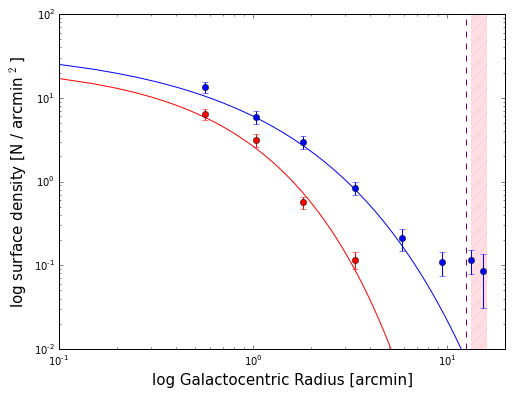

In [2062]:
n= index
rh=half_rad#np.true_divide(half_rad,60.)

bn= sersic_b(index)#1.9992*index - 0.3271
test = ((index*np.exp(bn)/bn**(2.*index)) *gamma(2.*index))

Nr =[]
for r in np.arange(0.1,20,0.05,dtype='f'):
    Nr.append(nh*np.exp(-bn*(((r/rh)**(1/n))-1)))
    #Nr.append(total_flux*np.exp(-bn*(((r/rh)**(1/n))-1)))# Reff was B[4][4]

E=surface_density(distances[(distances_flag== 'H')],P1[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],P2[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],DBins=np.true_divide(np.array([5,25,41,80]),60),scale='arcmin',plotting=False,match=True,blue_red = False)
F=surface_density(distances,P1[(Subaru_comp[Imag]<=22.5)],P2[(Subaru_comp[Imag]<=22.5)],DBins=np.array(np.true_divide([80,115,150,350,500,750],60)), match=True, plotting=False,index=2.0, blue_red = False)    

plt.figure(1,figsize=(8,6))    
plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr, c='grey') 
#plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr2, c='blue') 

plt.xlim(0.1,20)
plt.ylim(0.01,100)
#plt.scatter(R_blue,n_den_blue, c='blue')
#plt.scatter(R_red,n_den_red, c='red')
plt.scatter(E[2],(E[0]/E[1]), c='g')
plt.scatter(F[2],(F[0]/F[1]), c='orange')


plt.axvline((750./60.), ls ='--', c='purple')
#plt.axvline((360./60.), ls ='--', c='purple')
plt.axvspan(800./60., 950/60., color='pink', alpha=0.5, hatch ='//')
plt.xlabel('log Galactocentric Radius [arcmin]', size =15)
plt.ylabel('log surface density [N / arcmin $^2$]', size=15)

plt.yscale('log')
plt.xscale('log')
#plt.errorbar(R_blue,n_den_blue,xerr=0, yerr=error_blue, color='blue', fmt='.')
#plt.errorbar(R_red,n_den_red,xerr=0, yerr=error_red, color='red', fmt='.')
plt.errorbar(E[2],(E[0]/E[1]),xerr=0, yerr=E[3], color='green', fmt='.')
plt.errorbar(F[2],(F[0]/F[1]),xerr=0, yerr=F[3], color='orange', fmt='.')

plt.savefig('surface_density_revised.png')
plt.close()
#################################### BLUE AND RED ##############################################
plt.figure(2,figsize=(8,6))
rh_blue=np.true_divide(half_rad_blue,1.)
bn_blue= sersic_b(index_blue)

print nh_blue, index_blue, half_rad_blue

rh_red=np.true_divide(half_rad_red,1.)
bn_red= sersic_b(index_red)

print nh_red, index_red, half_rad_red



Nr_blue=[]
Nr_red=[]

for r in np.arange(0.1,20,0.05,dtype='f'):
    Nr_blue.append(nh_blue*np.exp(-bn_blue*(((r/rh_blue)**(1/index_blue))-1)))
    Nr_red.append(nh_red*np.exp(-bn_red*(((r/rh_red)**(1/index_red))-1)))

plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr_blue, c='blue') 
plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr_red, c='red') 

E_blue=surface_density(distances_blue[(distances_blue_flag== 'H')],P1[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],P2[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],DBins=np.true_divide(np.array([0,45,80]),60),scale='arcmin',plotting=False,match=True,blue_red = False)
F_blue=surface_density(distances_blue,P1[(Subaru_comp[Imag]<=22.5)],P2[(Subaru_comp[Imag]<=22.5)],DBins=np.array(np.true_divide([80,150
,450,750],60)), match=True, plotting=False,index=2.0, blue_red = False)    

E_red=surface_density(distances_red[(distances_red_flag== 'H')],P1[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],P2[(Subaru_comp[Imag]<=22.5)&(Subaru_comp['flag']== 'H')],DBins=np.true_divide(np.array([0,40,80]),60),scale='arcmin',plotting=False,match=True,blue_red = False)
F_red=surface_density(distances_red,P1[(Subaru_comp[Imag]<=22.5)],P2[(Subaru_comp[Imag]<=22.5)],DBins=np.array(np.true_divide([80,150,300,750],60)), match=True, plotting=False,index=2.0, blue_red = False)    

#plt.errorbar(E_blue[4],(E_blue[0]/E_blue[1]),xerr=0, yerr=E_blue[5], color='cyan', fmt='o')
#plt.errorbar(F_blue[4],(F_blue[0]/F_blue[1]),xerr=0, yerr=F_blue[5], color='blue', fmt='o')

#plt.errorbar(E_red[4],(E_red[0]/E_red[1]),xerr=0, yerr=E_red[5], color='pink', fmt='o')
#plt.errorbar(F_red[4],(F_red[0]/F_red[1]),xerr=0, yerr=F_red[5], color='red', fmt='o')

plt.axvline((750./60.), ls ='--', c='purple')
#plt.axvline((360./60.), ls ='--', c='purple')
plt.axvspan(800./60., 950/60., color='pink', alpha=0.5, hatch ='//')
plt.xlabel('log Galactocentric Radius [arcmin]', size =15)
plt.ylabel('log surface density [N / arcmin $^2$]', size=15)

plt.xlim(0.1,20)
plt.ylim(0.01,100)

plt.yscale('log')
plt.xscale('log')
################################################################################################
plt.errorbar(A[2],(A[5]/A[1]),xerr=0, yerr=A[7], color='red', fmt='o')
plt.errorbar(B[2],(B[5]/B[1]-0.09),xerr=0, yerr=B[7], color='red', fmt='o')

plt.errorbar(A[2],(A[6]/A[1]),xerr=0, yerr=A[8], color='blue', fmt='o')
plt.errorbar(B[2],(B[6]/B[1]-0.277),xerr=0, yerr=B[8], color='blue', fmt='o')
#######
plt.savefig(folder+'surface_density_revised2.png')



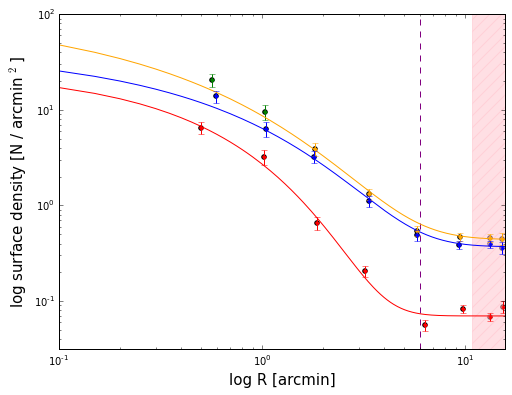

[ 19.37538438  10.92735782] [ 5.22005517  1.95382027  0.87650752  0.55448441  0.56282691  0.36905494
  0.4777236   0.45131489  0.45929585]


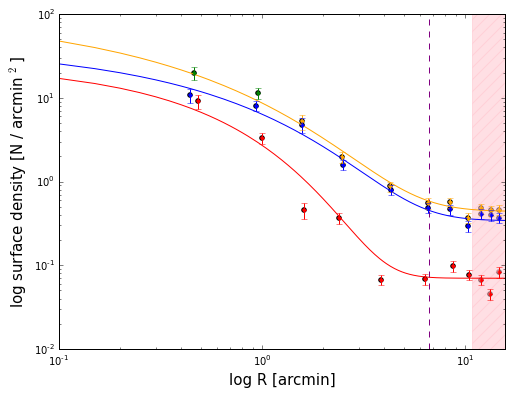

In [2063]:
plt.figure(figsize=(8,6))

plt.scatter(A[2],(A[0]/A[1]+0.44), c='green')
plt.scatter(B[2],(B[0]/B[1]), c='orange')

plt.scatter(A[10],(A[5]/A[1]+0.07), c='red')
plt.scatter(B[10],(B[5]/B[1]), c='red')

plt.scatter(A[9],(A[6]/A[1]+0.37), c='blue')
plt.scatter(B[9],(B[6]/B[1]), c='blue')

plt.axvline((400/60), ls ='--', c='purple')
plt.plot(np.arange(0.1,20,0.05,dtype='f'),np.array(Nr)+0.44, c='orange')
plt.plot(np.arange(0.1,20,0.05,dtype='f'),np.array(Nr_blue)+0.37, c='blue') 
plt.plot(np.arange(0.1,20,0.05,dtype='f'),np.array(Nr_red)+0.07, c='red') 


plt.xlabel('log R [arcmin]', size =15)
plt.ylabel('log surface density [N / arcmin $^2$]', size=15)

plt.yscale('log')
plt.xscale('log')
plt.errorbar(A[2],(A[0]/A[1]+0.44),xerr=0, yerr=A[3], color='green', fmt='.')
plt.errorbar(B[2],(B[0]/B[1]),xerr=0, yerr=B[3], color='orange', fmt='.')

plt.errorbar(A[10],(A[5]/A[1])+0.07,xerr=0, yerr=A[7], color='red', fmt='.')
plt.errorbar(B[10],(B[5]/B[1]),xerr=0, yerr=B[7], color='red', fmt='.')

plt.errorbar(A[9],(A[6]/A[1]+0.37),xerr=0, yerr=A[8], color='blue', fmt='.')
plt.errorbar(B[9],(B[6]/B[1]),xerr=0, yerr=B[8], color='blue', fmt='.')
plt.xlim(0.,950/60.)
plt.ylim(10**-1.5,10**2)
plt.axvspan(650/60., 950/60., color='pink', alpha=0.5, hatch ='//')
plt.savefig(folder+'log_surface_density_HST_SUB.png')
plt.show()


#################################### fixed colour cut ##########################
plt.figure(figsize=(8,6))
#plt.title('defined colour cut')
plt.scatter(C[2],(C[0]/C[1]+0.437), c='green')
plt.scatter(D[2],(D[0]/D[1]), c='orange')

plt.scatter(C[10],(C[5]/C[1]+0.144), c='red')
plt.scatter(D[10],(D[5]/D[1]), c='red')

plt.scatter(C[9],(C[6]/C[1]+0.292), c='blue')
plt.scatter(D[9],(D[6]/D[1]), c='blue')

plt.axvline((400./60.), ls ='--', c='purple')
plt.plot(np.arange(0.1,20,0.05,dtype='f'),np.array(Nr)+0.44, c='orange')
plt.plot(np.arange(0.1,20,0.05,dtype='f'),np.array(Nr_blue)+0.341, c='blue') 
plt.plot(np.arange(0.1,20,0.05,dtype='f'),np.array(Nr_red)+0.07, c='red') 


plt.xlabel('log R [arcmin]', size =15)
plt.ylabel('log surface density [N / arcmin $^2$]', size=15)

plt.yscale('log')
plt.xscale('log')
plt.errorbar(C[2],(C[0]/C[1]+0.437),xerr=0, yerr=C[3], color='green', fmt='.')
plt.errorbar(D[2],(D[0]/D[1]),xerr=0, yerr=D[3], color='orange', fmt='.')

plt.errorbar(C[10],(C[5]/C[1])+0.144,xerr=0, yerr=C[7], color='red', fmt='.')
plt.errorbar(D[10],(D[5]/D[1]),xerr=0, yerr=D[7], color='red', fmt='.')

plt.errorbar(C[9],(C[6]/C[1]+0.292),xerr=0, yerr=C[8], color='blue', fmt='.')
plt.errorbar(D[9],(D[6]/D[1]),xerr=0, yerr=D[8], color='blue', fmt='.')
plt.xlim(0.,950/60.)
plt.axvspan(650/60., 950/60., color='pink', alpha=0.5, hatch ='//')
plt.savefig(folder+'log_surface_density_HST_SUB2.png')



print C[4],D[4]
plt.show()

# straight line fit

In [2064]:
G=surface_density(GDist,P1[(Subaru_comp[Imag]<=22.5)],P2[(Subaru_comp[Imag]<=22.5)],DBins=np.array(np.true_divide([50,80,150,200,250,350],60)), match=True, plotting=False,index=2.0, blue_red = False)    
def power(x,k,n):
    output=np.array(k*x**(n))
    return output
sc.optimize.curve_fit(power,(G[2]),(G[0]/G[1]))

[1.0326517045002954, 1.865554952757555, 2.9288633006927496, 3.7308913819475125, 4.9296617117147257]


(array([ 12.49216063,  -1.85454256]), array([[ 0.02480082, -0.00305703],
        [-0.00305703,  0.00199654]]))

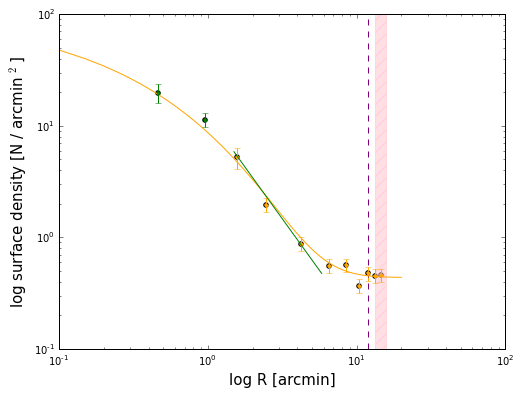

In [2065]:
plt.figure(figsize=(8,6))
#plt.title('defined colour cut')
plt.scatter(C[2],(C[0]/C[1]+0.437), c='green')
plt.scatter(D[2],(D[0]/D[1]), c='orange')

#plt.scatter(C[4],(C[7]/C[1]+0.144), c='red')
#plt.scatter(D[4],(D[7]/D[1]), c='red')

#plt.scatter(C[4],(C[8]/C[1]+0.292), c='blue')
#plt.scatter(D[4],(D[8]/D[1]), c='blue')

plt.axvline((750/60), ls ='--', c='purple')
plt.plot(np.arange(0.1,20,0.05,dtype='f'),np.array(Nr)+0.437, c='orange')
#plt.plot(np.arange(0.1,20,0.05,dtype='f'),np.array(Nr_blue)+0.292, c='blue') 
#plt.plot(np.arange(0.1,20,0.05,dtype='f'),np.array(Nr_red)+0.144, c='red') 


plt.xlabel('log R [arcmin]', size =15)
plt.ylabel('log surface density [N / arcmin $^2$]', size=15)

plt.errorbar(C[2],(C[0]/C[1]+0.437),xerr=0, yerr=C[3], color='green', fmt='.')
plt.errorbar(D[2],(D[0]/D[1]),xerr=0, yerr=D[3], color='orange', fmt='.')

#plt.errorbar(C[4],(C[7]/C[1])+0.144,xerr=0, yerr=C[9], color='red', fmt='.')
#plt.errorbar(D[4],(D[7]/D[1]),xerr=0, yerr=D[9], color='red', fmt='.')

#plt.errorbar(C[4],(C[8]/C[1]+0.292),xerr=0, yerr=C[10], color='blue', fmt='.')
#plt.errorbar(D[4],(D[8]/D[1]),xerr=0, yerr=D[10], color='blue', fmt='.')

#plt.xlim(0.,950/60.)
plt.axvspan(800/60., 950/60., color='pink', alpha=0.5, hatch ='//')

straight=np.arange(90,350,0.1)/60.
plt.plot((straight),((straight**-1.85)*12.4))
plt.yscale('log')
plt.xscale('log')

plt.show()

plt.figure(figsize=(8,6))    
plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr, c='orange') 
plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr_blue, c='blue') 
plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr_red, c='red') 

plt.xlim(0.1,20)
plt.ylim(0.01,100)


plt.axvline((750/60), ls ='--', c='purple')
plt.axvspan(800/60., 950/60., color='pink', alpha=0.5, hatch ='//')
plt.xlabel('log Galactocentric Radius [arcmin]', size =15)
plt.ylabel('log surface density [N / arcmin $^2$]', size=15)

plt.yscale('log')
plt.xscale('log')

plt.errorbar(A[4],(A[0]/A[1]),xerr=0, yerr=A[5], color='green', fmt='o')
plt.errorbar(B[4],(B[0]/B[1])-0.36666,xerr=0, yerr=B[5], color='orange', fmt='o')

plt.errorbar(A[4],(A[7]/A[1]),xerr=0, yerr=A[9], color='red', fmt='o')
plt.errorbar(B[4],(B[7]/B[1]-0.09),xerr=0, yerr=B[9], color='red', fmt='o')

plt.errorbar(A[4],(A[8]/A[1]),xerr=0, yerr=A[10], color='blue', fmt='o')
plt.errorbar(B[4],(B[8]/B[1]-0.277),xerr=0, yerr=B[10], color='blue', fmt='o')

plt.savefig('surface_density_background_subtracted.png')
plt.show()


plt.figure(figsize=(8,6))    
plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr, c='orange') 

plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr_blue, c='blue') 


plt.plot(np.arange(0.1,20,0.05,dtype='f'),Nr_red, c='red') 

plt.xlim(0.1,20)
plt.ylim(0.01,100)


plt.axvline((750/60), ls ='--', c='purple')
plt.axvspan(800/60., 950/60., color='pink', alpha=0.5, hatch ='//')
plt.xlabel('log Galactocentric Radius [arcmin]', size =15)
plt.ylabel('log surface density [N / arcmin $^2$]', size=15)

plt.yscale('log')
plt.xscale('log')

plt.errorbar(C[4],(C[0]/C[1]),xerr=0, yerr=C[5], color='green', fmt='o')
plt.errorbar(D[4],(D[0]/D[1])-0.366,xerr=0, yerr=D[5], color='orange', fmt='o')

plt.errorbar(C[4],(C[7]/C[1]),xerr=0, yerr=C[9], color='red', fmt='o')
plt.errorbar(D[4],(D[7]/D[1]-0.09),xerr=0, yerr=D[9], color='red', fmt='o')

plt.errorbar(C[4],(C[8]/C[1]),xerr=0, yerr=C[10], color='blue', fmt='o')
plt.errorbar(D[4],(D[8]/D[1]-0.277),xerr=0, yerr=D[10], color='blue', fmt='o')

plt.savefig('surface_density_background_subtracted_fixed_colour.png')
plt.show()

# defining total numbers of globular clusters

In [124]:
def sersic_new(number,sersic_index,half_light_radius,r):
    b_value= sersic_b(sersic_index)
    # b_value
    #f=(number*np.exp(-b_value*(((r/half_light_radius)**(1/sersic_index))-1))*(2*np.pi))
    
    f=(number*(2*np.pi*r)*np.exp(-b_value*((r/half_light_radius)**(1/sersic_index)-1)))
    return f

print nh,index,rh
print error_on_mean(half_light_radii)
results_total = integrate.quad(lambda x: sersic_new(nh,index,rh,r=x), 0, np.inf)
results_total_max = integrate.quad(lambda x: sersic_new(nh+error_on_mean(number_gc),index+error_on_mean(indexcies),rh+error_on_mean(np.array(half_light_radii)),r=x), 0, np.inf)
results_total_min = integrate.quad(lambda x: sersic_new(nh-error_on_mean(number_gc),index-error_on_mean(indexcies),rh-error_on_mean(half_light_radii),r=x), 0, np.inf)
print results_total[0]*2, results_total_min[0]*2, results_total_max[0]*2
print (-results_total_min[0]*2+ results_total_max[0]*2)/2


print 'blue'
print nh_blue,index_blue,rh_blue
results_blue = integrate.quad(lambda x: sersic_new(nh_blue,index_blue,rh_blue,r=x), 0., np.inf)
results_blue_max = integrate.quad(lambda x: sersic_new(nh_blue+error_on_mean(number_gc_blue),index_blue+error_on_mean(indexcies_blue),rh_blue+error_on_mean(half_light_radii_blue),r=x), 0,np.inf)
results_blue_min = integrate.quad(lambda x: sersic_new(nh_blue-error_on_mean(number_gc_blue),index_blue-error_on_mean(indexcies_blue),rh_blue-error_on_mean(half_light_radii_blue),r=x), 0, np.inf)
print results_blue[0]*2
print (-results_blue_min[0]*2+ results_blue_max[0]*2)/2


print'red'
print nh_red,index_red,rh_red
results_red = integrate.quad(lambda x: sersic_new(nh_red,index_red,rh_red,r=x), 0., np.inf)
results_red_max = integrate.quad(lambda x: sersic_new(nh_red+error_on_mean(number_gc_red),index_red+error_on_mean(indexcies_red),rh_red+error_on_mean(half_light_radii_red),r=x), 0, np.inf)
results_red_min = integrate.quad(lambda x: sersic_new(nh_red-error_on_mean(number_gc_red),index_red-error_on_mean(indexcies_red),rh_red-error_on_mean(half_light_radii_red),r=x), 0, np.inf)
print results_red[0]*2
print (-results_red_min[0]*2+ results_red_max[0]*2)/2
#print results_blue[0]*2+results_red[0]*2
#print results_total_max[0]*2,results_blue_max[0]*2,results_red_max[0]*2

#print results_blue_max[0]*2+results_red_max[0]*2
#print results_total_min[0]*2,results_blue_min[0]*2,results_red_min[0]*2
#print (results_total_max[0]+results_total_min[0])-results_total[0]*2
#print results_blue_min[0]*2+results_red_min[0]*2

NameError: name 'nh' is not defined

In [2067]:
print 'fractions through interpolation'
print 'blue'
print results_blue[0]/(results_blue[0]+results_red[0])
print 'red'
print results_red[0]/(results_blue[0]+results_red[0])
#fractions as per GMM


print 'blue GMM'
print sum(P1_new)/len(P1_new)
print 'red GMM'
print sum(P2_new)/len(P2_new)


print 'other estimates'
print 'blue GMM'
print sum(np.round(P1_new))/len(P1_new)
print 'red GMM'
print sum(np.round(P2_new))/len(P2_new)

fractions through interpolation
blue
0.795742536563
red
0.204257463437
blue GMM
0.779296224719
red GMM
0.220703775281
other estimates
blue GMM
0.746157303371
red GMM
0.253707865169


In [2089]:
Nb_Nr=results_blue[0]/results_red[0]
print Nb_Nr

3.89578193704


# Specific frequency
not quite clear which of the three cited ned values should be used 11.23 or 9.58???

In [4]:
T_V = 10**(0.4*((-21.38)+15))
T_V0 = 10**(0.4*((-21.38)+15))

print (50*T_V)
print (375*T_V0)

def specific_frequency(Mv,N):
    freq= N*(10**(0.4*((Mv)+15)))
    return freq

#print '3115',specific_frequency(21.07,781)

0.140271681898
1.05203761423


# Re relations (kartha comparisons)

In [5]:
names =['NGC','D','V0','Mv','logM','GCExt' ,'GCExt_err','N_gc', 'N_gc_err','Nb_Nr', 'Re','p']
df_kartha = pd.read_excel('Kartha_workbook.xlsx', sheetname='Sheet1',sep=',', na_values='nan')#, index_col='NGC')
df_kartha['Sn']=specific_frequency(df_kartha['Mv'],df_kartha['N_gc'])

df_kartha=df_kartha[~((df_kartha['Type']=='Sb')|(df_kartha['Type']=='Sa')|(df_kartha['Type']=='Sbc'))]
#df_kartha.columns((names))
print (len(df_kartha['NGC']))
for i in df_kartha.keys():
    print (i)

df_forbes = pd.read_excel('mnras-2.xlsx', sheetname='Sheet2')#, index_col='Galaxy')
df_forbes.columns=['NGC','Type','D','logM','Re','GC_re','GC_re_err','conversion_factor']
df_forbes['NGC']= df_forbes['NGC'].astype('str')
df_forbes['RevsGC_re'] = df_forbes['GC_re']/df_forbes['Re']
df_forbes['RevsGC_re_err'] = df_forbes['GC_re_err']/df_forbes['Re']
for i in df_forbes.keys():
    print (i)
df_forbes=df_forbes[~((df_forbes['Type']=='Sb')|(df_forbes['Type']=='Sa')|(df_forbes['Type']=='Sbc'))]

29
NGC
Type
Dist
V0
Mv
logM
GCExt
GCExt_err
N_gc
N_gc_err
Nb_Nr
Re
p
Sn
NGC
Type
D
logM
Re
GC_re
GC_re_err
conversion_factor
RevsGC_re
RevsGC_re_err


# Forbes 2017 (in prep)

In [6]:
#print df_forbes['NGC']
colour= []
exclude = np.array(['IC219','883','2695','2698','2699','5473','5485'])
for i in df_forbes['NGC'].isin(exclude):
    if i ==True:
        colour.append('r')
    else:
        colour.append('b')
#df_forbes['colour']=colour

In [7]:
#df_forbes[~df_forbes['NGC'].isin(exclude)]
df_kartha['Type']=='S0'

0     False
1     False
2      True
3     False
4      True
5     False
6     False
10    False
11    False
12     True
13    False
15    False
16    False
17    False
18     True
20    False
23    False
24    False
25    False
26    False
28    False
29    False
30     True
31     True
32    False
33    False
34     True
36     True
38     True
Name: Type, dtype: bool

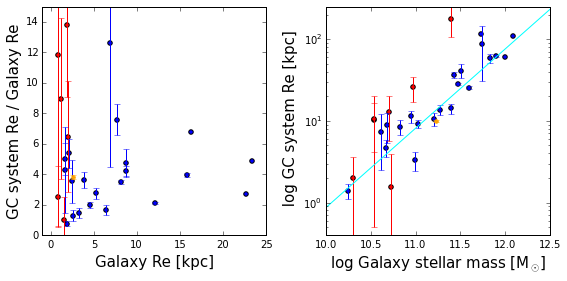

In [8]:
# re vs GC_re
mass_range= np.arange(10,13,0.25)

mass_fit = lambda x: 0.97*x-9.76


plt.figure(figsize=(8,4))
ax2=plt.subplot(121)
ax2=df_forbes[~df_forbes['NGC'].isin(exclude)].plot(x='Re', y='RevsGC_re',yerr='RevsGC_re_err', kind='scatter', grid='off', ylim=(0,15),xlim=(-1,25),c='b',ax=ax2)
df_forbes[df_forbes['NGC'].isin(exclude)].plot(x='Re', y='RevsGC_re',yerr='RevsGC_re_err', kind='scatter', grid='off', ylim=(0,15),xlim=(-1,25),c='r' ,ax=ax2)
plt.errorbar(2.6,9.89/2.6,yerr=0.13,color='orange', fmt='.', ms=8)
plt.xlabel('Galaxy Re [kpc]',size=15)
plt.ylabel('GC system Re / Galaxy Re',size=15)

ax=plt.subplot(122)
df_forbes[~df_forbes['NGC'].isin(exclude)].plot(x='logM', y='GC_re', kind='scatter', grid='off',ylim=(-10,250), xlim=(10,12.5),logy=True, yerr='GC_re_err',c='b', ax=ax)
df_forbes[df_forbes['NGC'].isin(exclude)].plot(x='logM', y='GC_re', kind='scatter', grid='off',ylim=(-10,250), xlim=(10,12.5), logy=True,yerr='GC_re_err',c='r', ax=ax)
plt.plot(mass_range,10** mass_fit(mass_range), ls='-', c='cyan')
plt.errorbar(11.23,9.89,yerr=0.336,color='orange', ms=8, fmt='.')
plt.xlabel('log Galaxy stellar mass [M$_\odot$]', size=15)
plt.ylabel(' log GC system Re [kpc]',size=15)
#plt.plot(mass_range, mass_fit(mass_range)  )
plt.savefig('images/gcrevslogM.png')
plt.tight_layout()
plt.show()

In [9]:
wlinear_fit(df_kartha['logM'][~df_kartha['GCExt'].isnull()], np.log10(df_kartha['GCExt'][~df_kartha['GCExt'].isnull()]),1/np.log10(df_kartha['GCExt_err'][~df_kartha['GCExt'].isnull()]))


NameError: name 'wlinear_fit' is not defined

# Merged cat.

In [9]:
df_merged=pd.merge(df_kartha, df_forbes, how = 'inner', left_on = 'NGC', right_on = 'NGC') # change to left for full sample!!

#print ((df_kartha['Type']=='Sb')|(df_kartha['Type']=='Sa')
#print df_merged['Type_x']
df_merged = df_merged[~((df_merged['Type_x']=='Sb')|(df_merged['Type_x']=='Sa')|(df_merged['Type_x']=='Sbc'))]



# Kartha Relations

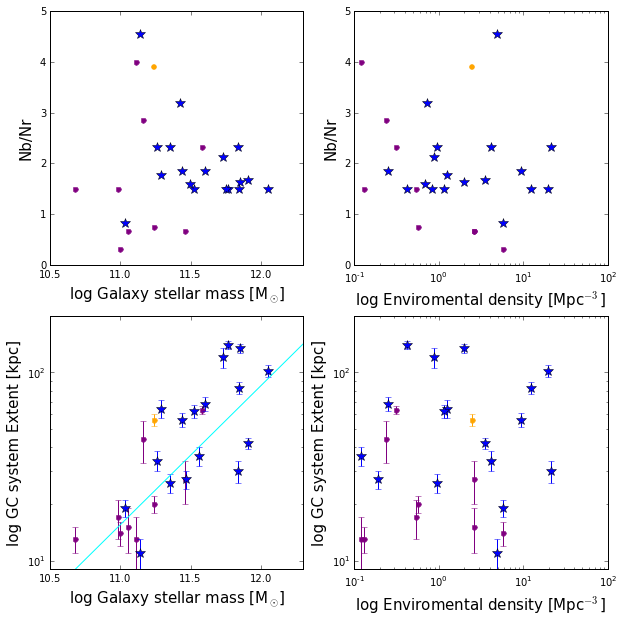

In [11]:
plt.figure(figsize=(10,10))
ax1=plt.subplot(221)
#plt.yscale('log')
ax1.errorbar(df_kartha['logM'][df_kartha['Type']=='S0'],df_kartha['Nb_Nr'][df_kartha['Type']=='S0'], c='purple',fmt='.', ms=10)
ax1.errorbar(df_kartha['logM'][df_kartha['Type']!='S0'],df_kartha['Nb_Nr'][df_kartha['Type']!='S0'], c='b',fmt='*', ms=10)#, c=np.log10(df_kartha['p']), cmap='rainbow')
ax1.scatter(11.24,3.896, color='orange')
plt.ylabel('Nb/Nr', size=15)
plt.xlabel('log Galaxy stellar mass [M$_\odot$]', size=15)
#plt.savefig('images/NbNrvslogM.png')

ax2=plt.subplot(222)
ax2.set_xscale('log')
ax2.errorbar(df_kartha['p'][df_kartha['Type']=='S0'],df_kartha['Nb_Nr'][df_kartha['Type']=='S0'],c='purple',fmt='.', ms=10)
ax2.errorbar(df_kartha['p'][df_kartha['Type']!='S0'],df_kartha['Nb_Nr'][df_kartha['Type']!='S0'],c='b',fmt='*', ms=10)
ax2.scatter(2.45,3.896, color='orange')
plt.ylabel('Nb/Nr', size=15 )
plt.xlabel('log Enviromental density [Mpc$^{-3}$]', size=15)
#plt.savefig('images/NbNrvsp.png')

ax3=plt.subplot(223, sharex=ax1)
ax3.set_yscale('log')
ax3.errorbar(x=df_kartha['logM'][df_kartha['Type']=='S0'],y=df_kartha['GCExt'][df_kartha['Type']=='S0'], yerr=df_kartha['GCExt_err'][df_kartha['Type']=='S0'], fmt='.', ms=10, c='purple')
ax3.errorbar(x=df_kartha['logM'][df_kartha['Type']!='S0'],y=df_kartha['GCExt'][df_kartha['Type']!='S0'], yerr=df_kartha['GCExt_err'][df_kartha['Type']!='S0'], fmt='*', ms=10, c='b')
ax3.errorbar(11.24,56,yerr=4 ,color='orange', fmt='.', ms= 10)
ax3.plot(mass_range,10**(-6.95+(mass_range)*0.74), c='cyan')
plt.xlim(10.5,12.3)
plt.ylim(0,200)
plt.ylabel('log GC system Extent [kpc]', size=15)
plt.xlabel('log Galaxy stellar mass [M$_\odot$]', size=15)
#plt.savefig('images/GCrevslogM.png')

ax4=plt.subplot(224,sharey=ax3)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.errorbar(x=df_kartha['p'][df_kartha['Type']=='S0'],y=df_kartha['GCExt'][df_kartha['Type']=='S0'],yerr=df_kartha['GCExt_err'][df_kartha['Type']=='S0'], fmt='.', ms=10, c='purple')
ax4.errorbar(x=df_kartha['p'][df_kartha['Type']!='S0'],y=df_kartha['GCExt'][df_kartha['Type']!='S0'],yerr=df_kartha['GCExt_err'][df_kartha['Type']!='S0'], fmt='*', ms=10, c='b')
ax4.errorbar(2.45,56,yerr=4 ,color='orange', fmt='.', ms= 10)
plt.ylabel('log GC system Extent [kpc]', size=15)
plt.xlabel('log Enviromental density [Mpc$^{-3}$]', size=15)
plt.ylim(0,200)
plt.savefig('images/kartha_relations.png')
#plt.close()
plt.show()

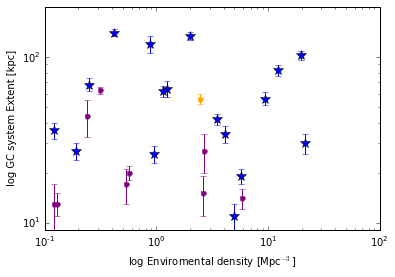

In [42]:
ax4=plt.subplot(111)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.errorbar(x=df_kartha['p'][df_kartha['Type']=='S0'],y=df_kartha['GCExt'][df_kartha['Type']=='S0'],yerr=df_kartha['GCExt_err'][df_kartha['Type']=='S0'], fmt='.', ms=10, c='purple')
ax4.errorbar(x=df_kartha['p'][df_kartha['Type']!='S0'],y=df_kartha['GCExt'][df_kartha['Type']!='S0'],yerr=df_kartha['GCExt_err'][df_kartha['Type']!='S0'], fmt='*', ms=10, c='b')
ax4.errorbar(2.45,56,yerr=4 ,color='orange', fmt='.', ms= 10)
plt.ylabel('log GC system Extent [kpc]')
plt.xlabel('log Enviromental density [Mpc$^{-3}$]')
plt.ylim(0,200)
plt.savefig('images/kartha_missing.png')

# Dark matter fraction relations

[ 19.1   8.7  16.2  14.1  11.4  18.4  14.3  20.7   9.8  14.9  12.9  17.4
  30.5   8.5  12.1  24.3   9.2]
[ 0.83]


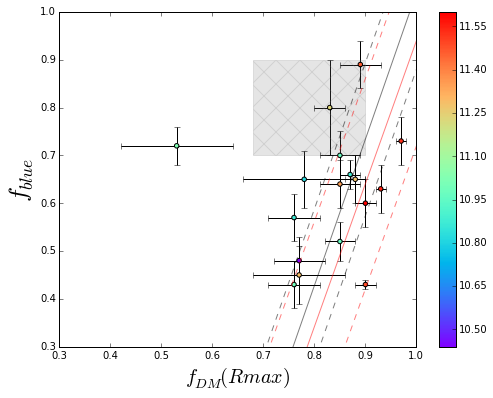

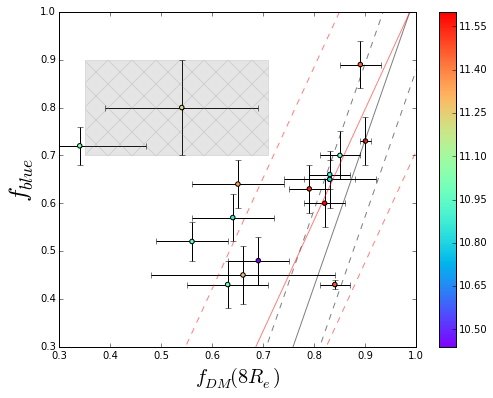

In [23]:
sluggs=np.loadtxt('Forbes2016_Table1.txt',usecols=(0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22), unpack=True)
#ideally replace all of the N4526 values with updated ones using insert()
ID=sluggs[0]
fb=sluggs[20]
err_fb=sluggs[21]
logM=sluggs[3]
fDM=sluggs[9]#[ID!=4526]
fDM_rmax=sluggs[18]
err_fDM=sluggs[10]#[ID!=4526]
err_fDM_rmax=sluggs[19]
rmax=sluggs[13]#[ID!=4526]
print rmax
points= np.arange(0.1,1.1,0.01)
scaling_relation =lambda x: 3.06*x-2.02
scaling_relation_new =lambda x: 2.99*x-2.05
scaling_relation_8re =lambda x: 2.32*x-1.29

plt.figure(figsize=(8,6))
plt.fill([0.68,0.9,0.9,0.68],[0.7,0.7,0.9,0.9], color='grey',alpha=0.2, edgecolor='grey', hatch='x')
plt.errorbar(fDM_rmax,fb,xerr=err_fDM_rmax,yerr=err_fb, fmt='.', zorder=1, c='black')
plt.scatter(fDM_rmax,fb,c=logM,cmap='rainbow', zorder=2)
#plt.errorbar(0.75,0.69,xerr=0.05,yerr=0.06, fmt='.', zorder=1, c='black')
#plt.plot(0.75,0.69,c='yellow',zorder=2, marker='*',ms=15)
plt.plot(points,scaling_relation(points), color='black', alpha=0.5)
plt.plot(points,scaling_relation(points)+0.16, c='black',linestyle='--', alpha=0.5)
plt.plot(points,scaling_relation(points)-0.16, c='black',linestyle='--', alpha=0.5)
plt.plot(points,scaling_relation_new(points), color='red',alpha=0.5)
plt.plot(points,scaling_relation_new(points)+0.22, c='red',linestyle='--',alpha=0.5)
plt.plot(points,scaling_relation_new(points)-0.22, c='red',linestyle='--',alpha=0.5)

plt.xlim(0.3,1)
plt.ylim(0.3,1)
plt.xlabel('$f_{DM}   (Rmax)$', size=20)
plt.ylabel('$f_{blue}$', size=25)
plt.colorbar()
plt.savefig('images/Dak_matter_fractions.png')

print fDM_rmax[ID==4526]

plt.figure(figsize=(8,6))
plt.fill([0.35,0.71,0.71,0.35],[0.7,0.7,0.9,0.9], color='grey',alpha=0.2, edgecolor='grey', hatch='x')
plt.errorbar(fDM,fb,xerr=err_fDM,yerr=err_fb, fmt='.', zorder=1, c='black')
plt.scatter(fDM,fb,c=logM,cmap='rainbow', zorder=2)
#plt.errorbar(0.55,0.69,xerr=0.1,yerr=0.06, fmt='.', zorder=1, c='black')
#plt.plot(0.55,0.69,c='yellow',zorder=2, marker='*',ms=15)
plt.plot(points,scaling_relation(points), c='black',alpha=0.5)
plt.plot(points,scaling_relation(points)+0.16, c='black',linestyle='--',alpha=0.5)
plt.plot(points,scaling_relation(points)-0.16, c='black',linestyle='--',alpha=0.5)
plt.plot(points,scaling_relation_8re(points), color='red',alpha=0.5)
plt.plot(points,scaling_relation_8re(points)+0.32, c='red',linestyle='--',alpha=0.5)
plt.plot(points,scaling_relation_8re(points)-0.32, c='red',linestyle='--',alpha=0.5)
plt.xlim(0.3,1)
plt.ylim(0.3,1)
plt.xlabel('$f_{DM}   (8 R_e)$', size=20)
plt.ylabel('$f_{blue}$', size=25)
plt.colorbar()
plt.savefig('images/Dak_matter_fractions_8Re.png')
plt.show()

In [24]:
from scipy.odr import *
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
linear= Model(f)
mydata = Data(fDM_rmax[(ID!=4494)&(ID!=4526)],fb[(ID!=4494)&(ID!=4526)], wd=1./sc.power(err_fDM_rmax[(ID!=4494)&(ID!=4526)],2), we=1./sc.power(err_fb[(ID!=4494)&(ID!=4526)],2))
myodr = ODR(mydata, linear, beta0=[1., 2.])
myoutput = myodr.run()
myoutput.pprint()


Beta: [ 3.08749815 -2.14686891]
Beta Std Error: [ 1.02635897  0.92446415]
Beta Covariance: [[ 0.32829102 -0.29538417]
 [-0.29538417  0.26634257]]
Residual Variance: 3.20877713148
Inverse Condition #: 0.0223392991008
Reason(s) for Halting:
  Sum of squares convergence


In [25]:
def rms(estimate,observed):
    rms= np.sqrt(np.mean((estimate-observed)**2))
    return rms
#1
pred1= 3.09*fDM_rmax[(ID!=4494)&(ID!=4526)]-2.15

print rms(pred1,fb[(ID!=4494)&(ID!=4526)])

#2
pred2= 3.00*fDM_rmax[(ID!=4494)]-2.06

print rms(pred2,fb[(ID!=4494)])

#3
pred1= 2.43*fDM[(ID!=4494)&(ID!=4526)]-1.37

print rms(pred1,fb[(ID!=4494)&(ID!=4526)])


#4
pred2= 2.46*fDM[(ID!=4494)]-1.4

print rms(pred2,fb[(ID!=4494)])



0.21650056351
0.218846407327
0.237350336001
0.32107046345


[ 19.1   8.7  16.2  14.1  11.4  18.4  14.3  20.7   9.8  14.9  12.9  17.4
  30.5   8.5  12.1  24.3   9.2]


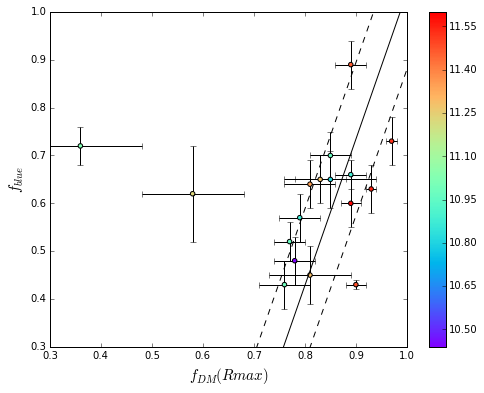

In [68]:
# Old plot Forbes 2016
ID=sluggs[0]
fb=sluggs[5]#[ID!=4526]
err_fb=sluggs[6]#[ID!=4526]
logM=sluggs[3]#[ID!=4526]
fDM=sluggs[9]#[ID!=4526]
fDM_rmax=sluggs[14]#[ID!=4526]
err_fDM=sluggs[10]#[ID!=4526]
err_fDM_rmax=sluggs[15]#[ID!=4526]
rmax=sluggs[13]#[ID!=4526]
print rmax
points= np.arange(0.1,1.1,0.01)
scaling_relation =lambda x: 3.06*x-2.02
plt.figure(figsize=(8,6))

plt.errorbar(fDM_rmax,fb,xerr=err_fDM_rmax,yerr=err_fb, fmt='.', zorder=1, c='black')
plt.scatter(fDM_rmax,fb,c=logM,cmap='rainbow', zorder=2)
#plt.errorbar(0.75,0.69,xerr=0.05,yerr=0.06, fmt='.', zorder=1, c='black')
#plt.plot(fDM_rmax[ID==4526],fb[ID==4526],c='yellow',zorder=2, marker='*',ms=15)
plt.plot(points,scaling_relation(points), c='black')
plt.plot(points,scaling_relation(points)+0.16, c='black',linestyle='--')
plt.plot(points,scaling_relation(points)-0.16, c='black',linestyle='--')
plt.xlim(0.3,1)
plt.ylim(0.3,1)
plt.xlabel('$f_{DM}   (Rmax)$', size=15)
plt.ylabel('$f_{blue}$', size=15)
plt.colorbar()
plt.savefig('Dak_matter_fractions_original.png')



In [54]:
print wlinear_fit(fDM_rmax[(ID!=4494)&(ID!=4526)],fb[(ID!=4494)&(ID!=4526)],(err_fDM_rmax[(ID!=4494)&(ID!=4526)]))
#np.var(fDM_rmax[ID!=4494])
print sc.stats.linregress(fDM_rmax[(ID!=4494)&(ID!=4526)],fb[(ID!=4494)&(ID!=4526)])

print ID[(ID!=4494)&(ID!=4526)],fb[(ID!=4494)&(ID!=4526)]

(-0.68386090440755654, 1.5330566685747, 23.017648565745713, 27.704684901454673, -636.67585991570002, 0.0051161017458500307)
(1.0772327964860906, -0.31149341142020481, 0.53198836057579668, 0.041228488850861743, 0.47554521971695618)
[  720.   821.  1023.  1407.  2768.  3115.  3377.  3607.  3608.  4278.
  4365.  4473.  4486.  4649.  4374.] [ 0.64  0.7   0.43  0.6   0.65  0.52  0.48  0.45  0.65  0.66  0.43  0.57
  0.73  0.63  0.89]


In [757]:
# calculating new scatter along the relation 
print len(ID),len(fDM_rmax)
predicted = 3.06*np.array(fDM_rmax[(ID!=4494)&(ID!=4526)])-2.02
rms_err= np.sqrt((np.sum ((predicted-fDM_rmax[(ID!=4494)&(ID!=4526)])**2))/len(predicted))

print rms_err



17 17
0.300087578328


In [758]:
alabi17=np.loadtxt('Busola_2017.txt', usecols=(8,17,10,19,6,15), unpack=True)

org_mass= (10**alabi17[3])/(10**11)
mass_max=(1-alabi17[0])*alabi17[-2]
fdm= 1- alabi17[3]/alabi17[-2]

print fdm-alabi17[1],'\n'
print mass_max,'\n','\n'
print np.round(org_mass-mass_max,2),'\n','\n'

[ -4.18461538  -2.29444444  -6.62875     -4.87636364  -0.52365591
  -1.52852941 -13.5025      -5.0547619  -14.77        -4.326       -2.5375
  -3.92555556  -0.59337349  -4.67090909  -6.61       -16.92        -0.42214008
  -6.87666667  -3.63275862 -11.46555556  -0.79567164  -0.54282609 -10.27
  -9.09909091  -0.62101266  -0.23186275  -1.75175439  -6.31529412] 

[ 1.664  0.855  0.848  1.012  3.348  1.496  0.736  0.756  0.266  2.1    0.92
  0.756  2.822  0.836  0.784  0.174  3.598  0.9    1.653  0.369  3.484
  2.392  0.66   0.132  3.002  2.448  2.394  0.799] 


[ 0.2   0.15  0.13  0.19  0.63  0.13  0.12  0.1   0.05  0.35  0.15  0.14
  0.41  0.12  0.13 -0.    0.57  0.15  0.17  0.01  0.5   0.49  0.02  0.
  0.55  0.71  0.18  0.07] 




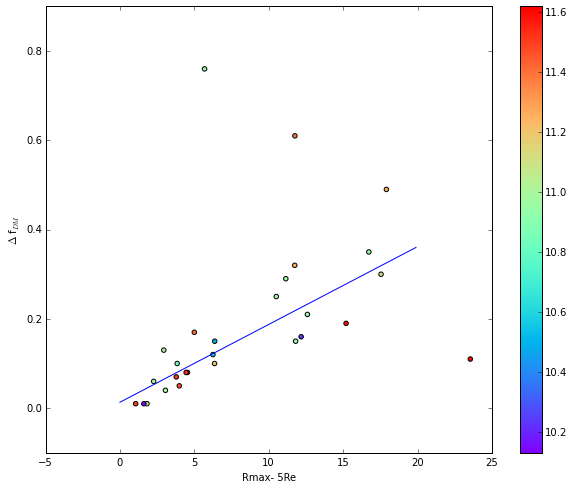

(0.017430304126893413, 0.013227113131620866)


In [1325]:
values= np.arange(0,20,0.1)
plt.figure(figsize=(10,8))
plt.scatter(alabi17[2]-5,alabi17[1]-alabi17[0],c=alabi17[3],cmap='rainbow')
slope, intercept, r_value, p_value, std_err = sc.stats.linregress(alabi17[2][((alabi17[1]-alabi17[0])<0.4)&(alabi17[2]-5<20)]-5,(alabi17[1]-alabi17[0])[((alabi17[1]-alabi17[0])<0.4)&(alabi17[2]-5<20)])
plt.plot(values,values*slope+intercept)
plt.xlabel('Rmax- 5Re')
plt.ylabel('$\Delta$ f$_{DM}$')
plt.colorbar()
plt.savefig('FDM with radius')

plt.show()
print (slope, intercept)

the greater the change in Re the greater the effect on fdm. However not nececarly the higher RE the higher fDM!


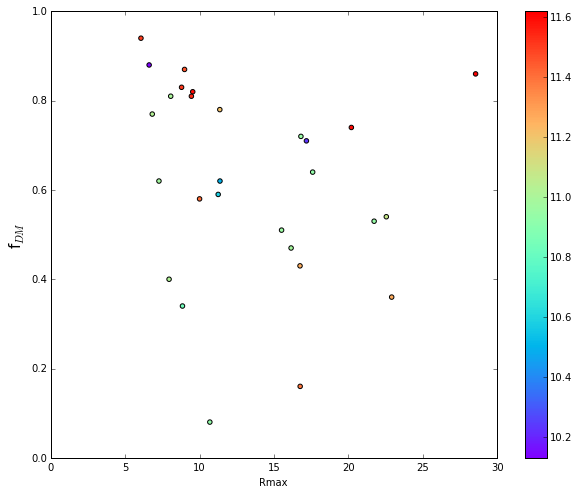

In [760]:
plt.figure(figsize=(10,8))
plt.scatter(alabi17[2],alabi17[0],c=alabi17[3],cmap='rainbow')
plt.xlabel('Rmax')
plt.ylabel('f$_{DM}$', size=15)
plt.colorbar()
plt.savefig('FDM with distance', size=15)

plt.show()

# Bluer then Blue population

assuming that there is a currently blue subset that is to become red hiding in the blue pop and therefore moving the colour peak.

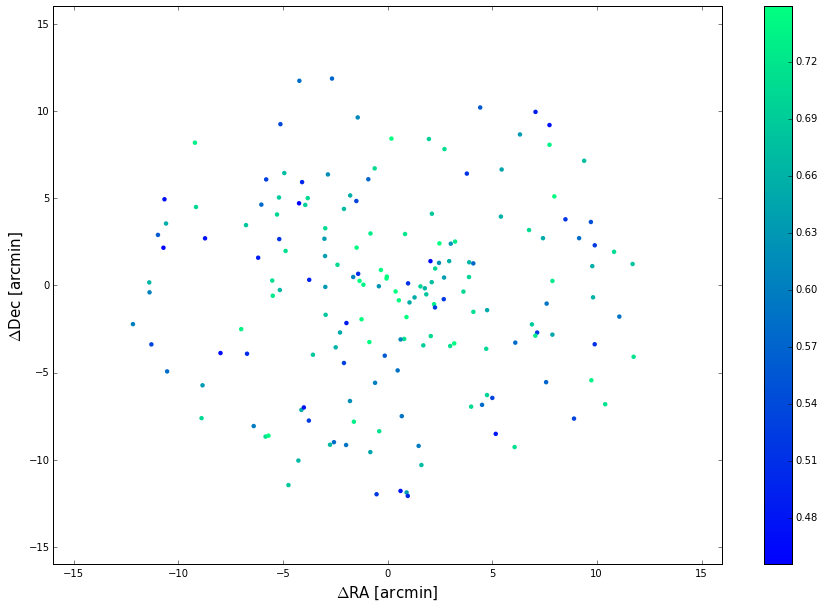

In [2371]:
fig =plt.figure(figsize=(15,10))
plt.ylabel('$\Delta$Dec [arcmin]',size=15)
plt.xlabel('$\Delta$RA [arcmin]',size=15)
ax = fig.add_subplot(1, 1, 1)

#plt.scatter(Subaru_comp['new_RA'][GDist<=750]-188.51262, Subaru_comp['new_Dec'][GDist<=750]-7.6991162, c=P1[GDist<=750], cmap='seismic')
#plt.scatter(Subaru_comp['new_RA'][outer_sub]-188.51262, Subaru_comp['new_Dec'][outer_sub]-7.6991162, c=P1[outer_sub], cmap='seismic')

inner = 0.222*60
outer = 0.264*60

x = np.linspace(-outer, outer, 1000, endpoint=True)

yO = outer*np.sin(np.arccos(x/outer)) # x-axis values -> outer circle
yI = inner*np.sin(np.arccos(x/inner)) # x-axis values -> inner circle (with nan's beyond circle)
yI[np.isnan(yI)] = 0.                 


#ax.fill_between(x, yI, yO, color="pink",alpha=0.5,edgecolor='None')
#ax.fill_between(x, -yO, -yI, color="pink", alpha=0.5,edgecolor='None')
plt.scatter((Subaru_comp['new_RA'][(GDist<=750)&(Subaru_comp[Imag]<22.5)&(np.round(P1)==1)&(Subaru_comp['g_i']<=0.75)&(Subaru_comp['g_i']>=0.45)]-188.51262)*60, (Subaru_comp['new_Dec'][(GDist<=750)&(Subaru_comp[Imag]<22.5)&(np.round(P1)==1)&(Subaru_comp['g_i']<=0.75)&(Subaru_comp['g_i']>=0.45)]-7.6991162)*60, c=Subaru_comp['g_i'][(GDist<=750)&(Subaru_comp[Imag]<22.5)&(np.round(P1)==1)&(Subaru_comp['g_i']<=0.75)&(Subaru_comp['g_i']>=0.45)], cmap='winter',edgecolor='None')
#plt.scatter((Subaru_comp['new_RA'][(GDist<=750)&(Subaru_comp[Imag]<22.5)&(np.round(P1)==1)&(Subaru_comp['g_i']<=0.45)&(Subaru_comp['g_i']>=0.3)]-188.51262)*60, (Subaru_comp['new_Dec'][(GDist<=750)&(Subaru_comp[Imag]<22.5)&(np.round(P1)==1)&(Subaru_comp['g_i']<=0.45)&(Subaru_comp['g_i']>=0.3)]-7.6991162)*60, c=Subaru_comp['g_i'][(GDist<=750)&(Subaru_comp[Imag]<22.5)&(np.round(P1)==1)&(Subaru_comp['g_i']<=0.45)&(Subaru_comp['g_i']>=0.3)], cmap='hot',edgecolor='None')
#plt.scatter((Subaru_comp['new_RA'][outer_sub]-188.51262)*60, (Subaru_comp['new_Dec'][outer_sub]-7.6991162)*60, c=np.round(P2[outer_sub]), cmap='bwr',edgecolor='None')
plt.colorbar()
plt.xlim(-16,16)
plt.ylim(-16,16)
plt.savefig('Area distribution most blue')
plt.show()

In [1168]:
np.arange(750,975,25)

array([750, 775, 800, 825, 850, 875, 900, 925, 950])

In [2372]:
def background_varition(min_no, max_no,itteration,colour=None):
    mid= (max_no+min_no)/2.
    densities=[]
    for b in range(itteration):
        i = random.randint(min_no,mid-20)
        p= random.randint(mid+20,max_no)
        outer_sub_test =[(GDist>i)&(GDist<p)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)& (Subaru_comp[Imag]<22.5)]
        outer_sub_test_blue =[(GDist>i)&(GDist<p)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)& (Subaru_comp[Imag]<22.5)&(P1>=0.5)]
        outer_sub_test_red =[(GDist>i)&(GDist<p)&(D_RA_sub<=(D_DEC_sub+1.25)/4.5)&(D_DEC_sub>=-0.25*D_RA_sub-0.25)& (Subaru_comp[Imag]<22.5)&(P2>=0.5)]
        
        area= ((p/60.)**2*np.pi) -((i/60.)**2*np.pi)
        if colour=='blue':
            density_at = len(GDist[outer_sub_test_blue])/area
            densities.append(density_at)
        if colour=='red':
            density_at = len(GDist[outer_sub_test_red])/area
            densities.append(density_at)
        else:
            density_at = len(GDist[outer_sub_test])/area
            densities.append(density_at)
        #print len(GDist[outer_sub_test]), area, density_at
    return np.median(densities), min(densities), max(densities)

In [2377]:
print 'total',background_varition(650, 950,100)
print 'blue', background_varition(650,950,100,'blue')
print 'red', background_varition(650,950,100,'red')

total (0.44734598598925257, 0.3727516165379105, 0.4700283099433679)
blue (0.41458196524465485, 0.3672414027117766, 0.46825579857046706)
red (0.061916124351813429, 0.034845088799539174, 0.07977614777604126)


In [1171]:
len(P2[(GDist>750)&(GDist<950)&(P2>=0.5)])/(((950/60.)**2*np.pi)-((750/60.)**2*np.pi))

0.0808881593125868

import numpy as np
import scipy.stats
import sys,os,commands
from scipy.special import gammainc as GammaINC
from os import path
from numpy import append
from scipy.special import gamma as Gamma
import math
from scipy import optimize
from scipy.optimize import fmin_powell



def dist(x1,y1,x2,y2):
    return np.hypot((x2-x1),(y2-y1))


def outliers_show(RV, RAD, RA, DEC):
    #clean data set!, remove outliers using friendless algorithm by Merrett et al 2003.
    N_nn= int(np.sqrt(len(RV)))
    tmp = []
    for i in range(len(RV)):
        temp = []
        for j in range(len(RV)):
            if j != i:
                temp.append(dist(RA[i], DEC[i], RA[j], DEC[j]))
        
        sep=np.asarray(temp)
        idx=np.argsort(sep)
        n_idx=idx[:N_nn]
        loc_vel_ave = np.average(RV[n_idx])
        loc_vel_dis = np.std(RV[n_idx])
        if np.abs(RV[i]-loc_vel_ave) > 3.0 * loc_vel_dis:
            tmp.append(i)
    f_idx = np.asarray(tmp)
    if len(f_idx) > 0 :
        print "there are outliers in the dataset, your attention is needed!"
    return f_idx

def afunc(x):
    global ros,paos,rvos,veos
    global ngc,k,pi
    global v_sys,q_phot,pa_phot,rad
    vrotc=x[0]
    sigmac=x[1]
    pakinc=x[2]
    # Sanity check that parameters are within reasonable range.
    if sigmac <0. or sigmac > 300.:
        return 999999.
    if pakinc <0. or pakinc>2.*pi:
        return 999999.
    if vrotc < 0. or vrotc > 300.:
        return 999999.
    lh=0.
    paos=paos/180.*pi
    for i in range(0,ngc):
        theta=paos[i]-pakinc
        while ((theta < 0.) or (theta > (2.*pi))) :
            if (theta<0.):
                theta=theta+2*pi
            elif (theta>(2.*pi)):
                theta=theta-2*pi
        if theta >= 0. and theta < (pi/2.) :
            v_exp=v_sys+vrotc/(math.sqrt(1.+(math.tan(theta)/q_phot)**2))
        elif theta >= (3.*pi/2.) and theta <= (2.*pi):
            v_exp=v_sys+vrotc/(math.sqrt(1.+(math.tan(theta)/q_phot)**2))
        else:
            v_exp=v_sys-vrotc/(math.sqrt(1.+(math.tan(theta)/q_phot)**2))
        lh=lh+((rvos[i]-v_exp)**2)/(sigmac**2+rveos[i]**2)+math.log(sigmac**2+rveos[i]**2)
    paos=paos/pi*180.
    return lh

def rotation_definition(file='ALL_rad_roll',percentile=50,columns =[2,3]):
    Vrot, sigma = np.loadtxt(file, unpack=True, usecols=columns)
    rot = Vrot/sigma
    #print scipy.stats.scoreatpercentile(Vrot[:], 50), scipy.stats.scoreatpercentile(Vrot[:], 50)-scipy.stats.scoreatpercentile(Vrot[:], 16), scipy.stats.scoreatpercentile(Vrot[:], 84)-scipy.stats.scoreatpercentile(Vrot[:], 50)
    #print scipy.stats.scoreatpercentile(sigma[:], 50), scipy.stats.scoreatpercentile(sigma[:], 50)-scipy.stats.scoreatpercentile(sigma[:], 16), scipy.stats.scoreatpercentile(sigma[:], 84)-scipy.stats.scoreatpercentile(sigma[:], 50)
    #print scipy.stats.scoreatpercentile(rot[:], 50), scipy.stats.scoreatpercentile(rot[:], 50)-scipy.stats.scoreatpercentile(rot[:], 16), scipy.stats.scoreatpercentile(rot[:], 84)-scipy.stats.scoreatpercentile(rot[:], 50)

    return scipy.stats.scoreatpercentile(Vrot[:], percentile),scipy.stats.scoreatpercentile(sigma[:], percentile),scipy.stats.scoreatpercentile(rot[:], percentile)


def Watkins(RAD, VELSQ, alpha, gamm, beta, item):
    rout = item #from Limber & Mathews+1960, An+2011(np.pi/4)
    for param1 in alpha:
        RAD = np.power(RAD, param1)
        mass_fac = np.average(np.multiply(RAD, VELSQ))
        for param2 in gamm:
            for param3 in beta:
                num_coeff = (param1+param2-2.*param3)*4.*Gamma(0.5*param1+2.5)*rout**(1.-param1)
                den_coeff = np.sqrt(np.pi)*(param1+3.-param3*(param1+2))*Gamma(0.5*param1+1.)
                coeffTME = num_coeff/den_coeff/4.3e-6
    return coeffTME * mass_fac

def define_masses_at_re(re_sampled=np.arange(1.,15.,1.)):
    masses_at_re =[]
    err_masses_at_re =[]
    for i in re_sampled:
    #extract mass @  5 R_e, 8 R_e and at max rad
        idx0 = np.nonzero(rad > i*r_e)[0][0]
        #print i
    #print mass estimates; iso, rad and tan
        #print("%4s \t %.2e \t %.2e \t %.2f \t %.2e \t %.2e" % ('4526', mass_W_I[idx0]*corr, mass_err_W_I[idx0], rad[-1]/r_e, mass_W_I[-1]*corr, mass_err_W_I[-1]))
        masses_at_re.append(mass_W_I[idx0]*corr)
        err_masses_at_re.append(mass_err_W_I[idx0])
        #print("%4s \t %.2e \t %.2e \t %.2f \t %.2e \t %.2e" % ('4526', mass_W_R[idx0]*corr, mass_err_W_R[idx0], rad[-1]/r_e, mass_W_R[-1]*corr, mass_err_W_R[-1]))
        #print("%4s \t %.2e \t %.2e \t %.2f \t %.2e \t %.2e" % ('4526', mass_W_T[idx0]*corr, mass_err_W_T[idx0], rad[-1]/r_e, mass_W_T[-1]*corr, mass_err_W_T[-1]))
        #print('##################################################################################')
    return masses_at_re, err_masses_at_re

def get_mass(r_e, max_rad, Vrot, err_l, err_u, mdyn, mdyn_err, corr):

    N=10000
    m_rot5 = max_rad * r_e * Vrot**2/4.302e-6
    mass_1 = np.empty(N)
    mass_3 = np.empty(N)
    for i in range(N):
        first = np.random.normal(Vrot, 0.5*err_l, 1)
        second = np.random.normal(mdyn, mdyn_err, 1)
        third = np.random.normal(max_rad, max_rad*0.15, 1)
        mass_1[i] = max_rad  * first**2/4.302e-6
        mass_3[i] = mass_1[i] + second*corr
    l_err_rot = np.percentile(mass_1[i], 50)-np.percentile(mass_1[i], 16)
    u_err_rot = np.percentile(mass_1[i], 84)-np.percentile(mass_1[i], 50)
    err_rot = np.mean([l_err_rot, u_err_rot])
    return (m_rot5, np.std(mass_1),  m_rot5+mdyn, np.std(mass_3))


def get_f_dm(M_star, err, max_rad, tot_mass5, tot_mass5_err, r_e, n_S):
    N=1000
    b = 2*n_S-(1./3.)+(0.009876/n_S)+(0.0018/n_S**2)
    p = 1.-(0.6097/n_S)+(0.05563/n_S**2)
    M_star5 = M_star * GammaINC((3.-p)*n_S, b*(1.34*max_rad)**(1./n_S))
    real_fdm5 =  1.-(M_star5/tot_mass5)
    real_MDM_Mstar5 =  tot_mass5/M_star5
    real_rhodm5 =  3.*(tot_mass5-M_star5)/(4.*np.pi*(max_rad*r_e)**3)

    f_dm5 = np.empty(N)
    MDM_Mstar5 = np.empty(N)
    rhodm5 = np.empty(N)

    for i in range(N):
        second = np.random.normal(tot_mass5, tot_mass5_err, 1)
        fifth = np.random.normal(M_star5, err, 1)
        f_dm5[i] = 1-(fifth/second)
        MDM_Mstar5[i] = second/fifth
        rhodm5[i] = 3.*(second-fifth)/(4.*np.pi*(max_rad*r_e)**3)
    return (real_fdm5, np.std(f_dm5))


input_file='NGC4526.cat'

#def calculate_dark_matter_fraction(RV_file):
#input_file=RV_file
all_rad_file='ALL_rad_roll_'+input_file
mass_estW_ISO='mass_estW_ISO_'+input_file
mass_estW_RAD='mass_estW_RAD_'+input_file
mass_estW_TAN='mass_estW_TAN_'+input_file


out=open(all_rad_file,'w')
out.write('#it \t\t rad \t\t Vrot \t\t sigma \t\t PAkin \t\t lh/dof \n')

nbs=30
v_sys=617.
pi=math.pi
q_phot=0.24
pa_phot=(113.7)*pi/180.0
friendless=True
RA0 = 188.512856
DEC0 = 7.699524
Vsys = 617.
Q = 0.24
PA0 = 113.7
Dist = 16.4
Re_arc = 32.4
Re_kpc = 2.576
M_star = 11.26

corr=0.77
gal = 'N4526'
r_e = 2.576 #Re in kpc, Duncan's paper
n_S = 3.6 #Sersic Index, Duncan's paper

data = np.loadtxt(input_file, dtype={'names':('ID', 'RA', 'DEC', 'RV', 'RV_err', 'col', 'PA', 'RAD'), 'formats':('|S20', np.float, np.float, np.float, np.float, np.float, np.float, np.float)})

ID = data['ID']
RA =data['RA']
DEC=data['DEC']
RV=data['RV']
RV_err=data['RV_err']
col=data['col']
RAD=data['RAD']
PA=data['PA']


if friendless==True:
    print "Welcome, rot-sig estimation routine!"
    print "+++++++++++++++++++++++++++++++++"
    print ""
    print "There are ", len(ID), "objects in your dataset, before cleaning"

    no_print = outliers_show(RV, RAD, RA, DEC)
    fRAD = np.empty(len(no_print))
    fRV = np.empty(len(no_print))

    for i in range(len(no_print)):
        print ID[no_print[i]]
        fRAD[i] = RAD[no_print[i]]
        fRV[i] = RV[no_print[i]]

    #clean friendless objects from parent dataset, and update (not writing to file!!!)
    ID = np.delete(ID, list(no_print))
    RA = np.delete(RA, list(no_print))
    DEC = np.delete(DEC, list(no_print))
    RV = np.delete(RV, list(no_print))
    RV_err = np.delete(RV_err, list(no_print))
    col = np.delete(col, list(no_print))
    PA = np.delete(PA, list(no_print))
    RAD = np.delete(RAD, list(no_print))


    print "dataset now has ", len(ID), "objects, after cleaning"
    #return(ID,RA,DEC,RV,RV_err,col,PA,RAD)
ngc = len(RA)

# ORDERING BY GALACTOCENTRIC RADIUS:            #kin.py
# All GCs:          #kin.py
inds=np.argsort(RAD)            #kin.py
ros=RAD[inds]           #kin.py
paos=PA[inds]           #kin.py
rvos=RV[inds]           #kin.py
rveos=RV_err[inds]          #kin.py
            #kin.py
# INITIAL GUESS:            #kin.py
x0=np.zeros(3)          #kin.py
x0[0]=80.           #kin.py
x0[1]=200.          #kin.py
x0[2]=pa_phot           #kin.py

# Bootstrapping:
randind=[]
for i in range(0,ngc):
    randind.append(0)

for j in range (0,nbs-1):
    #print j
    # Randomizing all GCs:
    for i in range(0,ngc):
        randind[i]=random.randint(0,ngc) # assigning random index
    randrs=RAD[randind]
    randpas=PA[randind]
    randrvs=RV[randind]
    randrves=RV_err[randind]

    # ORDERING BY GALACTOCENTRIC RADIUS:
    # ALL GCs:
    inds=np.argsort(randrs)
    ros=randrs[inds]
    paos=randpas[inds]
    rvos=randrvs[inds]
    rveos=randrves[inds]

    # INITIAL GUESS:
    x0=np.zeros(3)
    x0[0]=60.
    x0[1]=130.
    x0[2]=pi

# MINIMIZING USING POWELL'S METHOD for all GCs:
    rad=0.
    rad=sum(ros[0:ngc])/float(ngc)
    powellout=fmin_powell(afunc,x0,ftol = 1e-6, xtol=1e-6, maxiter = None,full_output=1,disp=0)
    xopt=powellout[0]
    #using last fit as new initial guess:
    x0=xopt
    #print j+1,rad,xopt[0],xopt[1],(xopt[2]/pi*180.),powellout[1]/float(ngc-3)
    out.write(str(j+1)+'\t'+str(rad)+'\t'+str(xopt[0])+'\t'+str(xopt[1])+'\t'+str((xopt[2]/pi*180.))+'\t'+str(powellout[1]/float(ngc-3))+'\n')

#out1=open('FRIENDLESS','w')
#out1.write('#ID \t RA \t DEC \t RV \t RV_err \t col \t PA \t RAD \t \n')
out.close()
out4=open(mass_estW_ISO,'w')
out4.write('#N_GC \t max_rad \t mass \t l_mass \t u_mass \t \n')
out5=open(mass_estW_RAD,'w')
out5.write('#N_GC \t max_rad \t mass \t l_mass \t u_mass \t \n')
out6=open(mass_estW_TAN,'w')
out6.write('#N_GC \t max_rad \t mass \t l_mass \t u_mass \t \n')

#det gamm and alpha parameter
gamm_param = -0.63*M_star+9.81
alp_param = -0.46*M_star+5.29
#define alpha, beta and gamma
gamm = [gamm_param]
alpha = [alp_param]
beta = [[0.], [0.5], [-0.5]]


Vrot = rotation_definition(file=all_rad_file,percentile=50,columns =[2,3])[0]#88.57
err_l = rotation_definition(file=all_rad_file,percentile=16,columns =[2,3])[0]#27.8421455382 #16th percentile
err_u = rotation_definition(file=all_rad_file,percentile=84,columns =[2,3])[0] #84th percentile

RV -= Vsys
RV -= Vrot
RAD = RAD * Re_kpc/Re_arc
#sort data by RAD before analysis
indx = np.argsort(RAD)
RV = RV[indx]
RV_err = RV_err[indx]
RAD = RAD[indx]

N=1000 #number of iterations for Montecarlo simulations
idx = np.nonzero(RAD > 2.*Re_kpc)[0] #returns index of GCs greater than 2R_e

mass_est_err0 = np.ones(N)
mass_est_err1 = np.ones(N)
mass_est_err2 = np.ones(N)

for k in range(len(idx)):
    rad_lim = RAD[idx[k]]
    aRAD = RAD[np.where(np.logical_and(RAD < rad_lim, 1))]
    aRV = RV[np.where(np.logical_and(RAD < rad_lim, 1))]
    aRV_err = RV_err[np.where(np.logical_and(RAD < rad_lim, 1))]
    #real_mass, without Monte Carlo simulations
    real_mass_est0 = Watkins(aRAD, np.square(aRV), alpha, gamm, beta[0], rad_lim)
    real_mass_est1 = Watkins(aRAD, np.square(aRV), alpha, gamm, beta[1], rad_lim)
    real_mass_est2 = Watkins(aRAD, np.square(aRV), alpha, gamm, beta[2], rad_lim)
    #Now Monte Carlo, that makes use of RV_err and sampling without replacement
    for j in range(N):
        scr_RV = np.ones(len(aRV))
        for i in range(len(aRV)):
            scr_RV[i] = np.random.normal(aRV[i], aRV_err[i], 1)
        VELSQ = np.square(scr_RV)
        mass_est_err0[j] = 1.402*Watkins(aRAD, VELSQ, alpha, gamm, beta[0], rad_lim)/np.sqrt(len(aRAD))
        mass_est_err1[j] = 1.402*Watkins(aRAD, VELSQ, alpha, gamm, beta[1], rad_lim)/np.sqrt(len(aRAD))
        mass_est_err2[j] = 1.402*Watkins(aRAD, VELSQ, alpha, gamm, beta[2], rad_lim)/np.sqrt(len(aRAD))

    out4.write("%3i \t %.3f \t %.5e \t %.5e \t %.5e \n" % (len(aRAD), rad_lim, real_mass_est0, scipy.stats.scoreatpercentile(mass_est_err0[:], 16), scipy.stats.scoreatpercentile(mass_est_err0[:], 84)))
    out5.write("%3i \t %.3f \t %.5e \t %.5e \t %.5e \n" % (len(aRAD), rad_lim, real_mass_est1, scipy.stats.scoreatpercentile(mass_est_err1[:], 16), scipy.stats.scoreatpercentile(mass_est_err1[:], 84)))
    out6.write("%3i \t %.3f \t %.5e \t %.5e \t %.5e \n" % (len(aRAD), rad_lim, real_mass_est2, scipy.stats.scoreatpercentile(mass_est_err2[:], 16), scipy.stats.scoreatpercentile(mass_est_err2[:], 84)))
out4.close()
out5.close()
out6.close()

#read input files
ngc, rad, mass_W_I, lmass_err_W_I, umass_err_W_I = np.loadtxt(mass_estW_ISO, unpack=True, usecols=[0,1,2,3,4])
mass_err_W_I = np.maximum(lmass_err_W_I, umass_err_W_I)
mass_W_R, lmass_err_W_R, umass_err_W_R = np.loadtxt(mass_estW_RAD, unpack=True, usecols=[2,3,4])
mass_err_W_R = np.maximum(lmass_err_W_R, umass_err_W_R)
mass_W_T, lmass_err_W_T, umass_err_W_T = np.loadtxt(mass_estW_TAN, unpack=True, usecols=[2,3,4])
mass_err_W_T = np.maximum(lmass_err_W_T, umass_err_W_T)

effective_radii_to_investigate=np.arange(3.,12.,1.)
m5 = define_masses_at_re(effective_radii_to_investigate)[0]#2.66e+11#mass within 5/8/Rmax 3.52e+11 8.35e+10 
m5err = define_masses_at_re(effective_radii_to_investigate)[1]#7.86e+10 #uncertainty
max_rad = effective_radii_to_investigate#5.  #5/8/Rmax

#M_star += 0.2
M_star = 10**M_star
mstar_err = 0.10*M_star
dm_frac = []
dm_frac_err = []
mass_re=[]
mass_re_max=[]
mass_re_err=[]
mass_re_max_err=[]
#obtain parameters and uncertainties on calculated parameters
######################## Needs to loop over all the Vrot values
for i in range(len(max_rad)):
    m_rot5, m_rot5_err, tot_mass5, tot_mass5_err = get_mass(r_e, max_rad[i], Vrot, err_l, err_u, m5[i], m5err[i], corr)
    f_dm5, f_dm5_err = get_f_dm(M_star, mstar_err, max_rad[i], tot_mass5, tot_mass5_err, r_e, n_S)
    dm_frac.append(f_dm5)
    dm_frac_err.append(f_dm5_err)
    mass_re.append(m_rot5)
    mass_re_max.append(tot_mass5)
    mass_re_err.append(m_rot5_err)
    mass_re_max_err.append(tot_mass5_err)
    print("%5s \t %.2e \t %.2e \t %.2e \t %.2e \t %.2e \t %.2e \t %.2f \t %.2f \n" % (str(gal), m_rot5, m_rot5_err, m5[i], m5err[i], tot_mass5, tot_mass5_err, f_dm5, f_dm5_err))
#"%5s \t %.2e \t %.2e \t %.2e \t %.2e \t %.2e \t %.2e \t %.2f \t %.2f \n" %
#4526    2.66e+11    7.86e+10    16.75   6.52e+11    1.35e+11
#return (max_rad, m_rot5, m_rot5_err, m5[i], m5err[i], tot_mass5, tot_mass5_err, f_dm5, f_dm5_err)



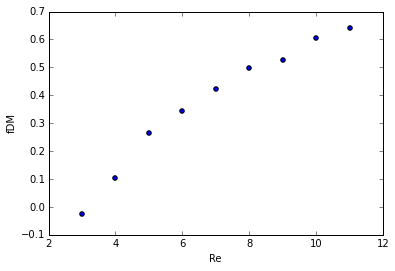

In [1329]:
#print len(effective_radii_to_investigate),len(f_dm5)

plt.figure()
plt.scatter(effective_radii_to_investigate, (np.array(m5)-10**(11.26))/np.array(m5))
plt.xlabel('Re')
plt.ylabel('fDM')
plt.savefig('images/fdm_at_diff_re.png')
plt.show()